In [ ]:
#!pip install catboost

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from IPython.display  import display, HTML
import warnings
from colorama import Fore, Style

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import randint
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
da= pd.read_csv('creditcard_2023.csv')
da

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


Data understanding

In [9]:
from IPython.display import display, HTML

def styled_heading(text, background_color='#14adc6', text_color='white'):
    return f"""
    <p style="
        background-color: {background_color};
        font-family: Pacifico, cursive;
        font-size: 150%;
        color: {text_color};
        text-align: center;
        border-radius: 10px;
        padding: 10px;
        font-weight: normal;
        box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);
        width: fit-content;
        margin: 0 auto;
    ">
        {text}
    </p>
    """

def style_table(df):
    styled_df = df.style.set_table_styles([
        {"selector": "th", "props": [("color", "white"), ("background-color", "#14adc6")]}
    ]).set_properties(**{"text-align": "center"}).hide(axis="index")
    return styled_df.to_html()

def print_dataset_analysis(train_dataset, n_top=5, heading_color='#14adc6', text_color='white'):
    train_heading = styled_heading(f"📊 Basic Data Overview", heading_color, text_color)
    display(HTML(train_heading))
    display(HTML(style_table(train_dataset.head(n_top))))

    summary_heading = styled_heading("🔍 Data Summary", heading_color, text_color)
    display(HTML(summary_heading))
    display(HTML(style_table(train_dataset.describe())))

    null_heading = styled_heading("🚫 Null Values in Data", heading_color, text_color)
    train_null_count = train_dataset.isnull().sum()
    display(HTML(null_heading))
    if train_null_count.sum() == 0:
        display(HTML("<p>No null values in the dataset.</p>"))
    else:
        display(HTML("<h3>Null Values:</h3>"))
        display(HTML(style_table(train_null_count[train_null_count > 0].to_frame())))
        display(HTML("<p>These are the null values.</p>"))

    duplicate_heading = styled_heading("♻️ Duplicate Values in Data", heading_color, text_color)
    train_duplicates = train_dataset.duplicated().sum()
    display(HTML(duplicate_heading))
    display(HTML("<h3>Duplicates:</h3>"))
    display(HTML(f"<p>{train_duplicates} duplicate rows found.</p>"))

    shape_heading = styled_heading("📏 Data Shape", heading_color, text_color)
    display(HTML(shape_heading))
    display(HTML("<h3>Shape:</h3>"))
    display(HTML(f"<p>Rows: {train_dataset.shape[0]}, Columns: {train_dataset.shape[1]}</p>"))

def print_unique_values(train_dataset, heading_color='#14adc6', text_color='white'):
    unique_values_heading = styled_heading("🔢 Unique Values in Data", heading_color, text_color)
    display(HTML(unique_values_heading))
    unique_values_table = pd.DataFrame({
        'Column Name': train_dataset.columns,
        'Data Type': [train_dataset[col].dtype for col in train_dataset.columns],
        'Unique Values': [', '.join(map(str, train_dataset[col].unique()[:7])) for col in train_dataset.columns]
    })
    display(HTML(style_table(unique_values_table)))

print_dataset_analysis(da, n_top=5, heading_color='#14adc6', text_color='white')
print_unique_values(da, heading_color='#14adc6', text_color='white')

id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.100000,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.370000,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.540000,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.440000,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.970000,0


id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000
284314.500000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,12041.957635,0.500000
164149.486121,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,6919.644449,0.500000
0.000000,-3.495584,-49.966572,-3.183760,-4.951222,-9.952786,-21.111108,-4.351839,-10.756342,-3.751919,-3.163276,-5.954723,-2.020399,-5.955227,-2.107417,-3.861813,-2.214513,-2.484938,-2.421949,-7.804988,-78.147839,-19.382523,-7.734798,-30.295450,-4.067968,-13.612633,-8.226969,-10.498633,-39.035243,50.010000,0.000000
142157.250000,-0.565286,-0.486678,-0.649299,-0.656020,-0.293496,-0.445871,-0.283533,-0.192257,-0.568745,-0.590101,-0.701449,-0.831133,-0.696667,-0.873206,-0.621249,-0.716265,-0.619491,-0.556046,-0.565308,-0.350240,-0.166441,-0.490489,-0.237629,-0.651580,-0.554148,-0.631895,-0.304961,-0.231878,6054.892500,0.000000
284314.500000,-0.093638,-0.135894,0.000353,-0.073762,0.081088,0.078718,0.233366,-0.114524,0.092526,0.262614,-0.041050,0.162052,0.017608,0.230501,-0.039256,0.134026,0.271641,0.087294,-0.025979,-0.123378,-0.037431,-0.027329,-0.059689,0.015901,-0.008193,-0.011892,-0.172911,-0.013930,12030.150000,0.500000
426471.750000,0.832658,0.343555,0.628538,0.707005,0.439737,0.497788,0.525955,0.047299,0.559262,0.592460,0.747773,0.744672,0.685605,0.751822,0.665406,0.655606,0.518224,0.544389,0.560116,0.248216,0.147979,0.463882,0.155715,0.700737,0.550015,0.672888,0.334023,0.409590,18036.330000,1.000000
568629.000000,2.229046,4.361865,14.125834,3.201536,42.716891,26.168402,217.873038,5.958040,20.270062,31.722709,2.513573,17.913556,7.187486,19.169544,14.532202,46.652906,6.994124,6.783716,3.831672,29.872812,8.087080,12.632511,31.707627,12.965639,14.621509,5.623285,113.231093,77.255937,24039.930000,1.000000


Column Name,Data Type,Unique Values
id,int64,"0, 1, 2, 3, 4, 5, 6"
V1,float64,"-0.2606478048943981, 0.9850997342386376, -0.2602716127429705, -0.1521521019135671, -0.2068195207397724, 0.0253022918437197, 1.016481733774662"
V2,float64,"-0.4696484500536342, -0.3560450929163436, -0.949384606645412, -0.508958707673651, -0.1652802037771797, -0.1405138106986785, -0.3971805392710764"
V3,float64,"2.496266082631564, 0.5580563509382045, 1.7285377761514875, 1.746840058804548, 1.5270526784614766, 1.1911377729432049, 0.4978676895018615"
V4,float64,"-0.0837239126781463, -0.4296539034065106, -0.4579862888424837, -1.090177941714601, -0.4482926629585126, -0.7079788118561594, -0.1444627937175796"
V5,float64,"0.1296812361545678, 0.2771402629466986, 0.0740616543492221, 0.2494857726542817, 0.1061251141654366, 0.4304903210757426, 0.3310218239728978"
V6,float64,"0.7328982498449426, 0.4286045153379263, 1.4194811432767418, 1.143312263314309, 0.5305488615008258, 0.458973191695661, 0.6292427694008561"
V7,float64,"0.5190136179018007, 0.4064660422512956, 0.7435110747693963, 0.5182685727677246, 0.658849134344094, 0.611049586735272, 0.4312624487933091"
V8,float64,"-0.1300060475886773, -0.1331182741764908, -0.0955760133714609, -0.0651299167095495, -0.2126600114747583, -0.0926286061215454, -0.1340074521768929"
V9,float64,"0.7271592691096374, 0.3474518951767279, -0.2612966191422005, -0.2056976045189998, 1.0499208392737625, 0.1808113568188648, 0.7961590291922901"


In [10]:
#Remove the id column
da.drop(columns= 'id', inplace= True)
da.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


Feature importance


In [11]:
import xgboost as xgb
import pandas as pd
import numpy as np

In [12]:
# Split features and target
X = da.iloc[:, :-1]  
y = da.iloc[:, -1]  

In [13]:
model = xgb.XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
importance = model.feature_importances_

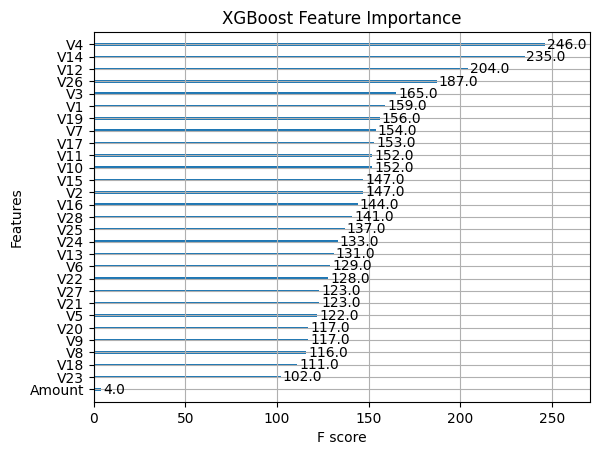

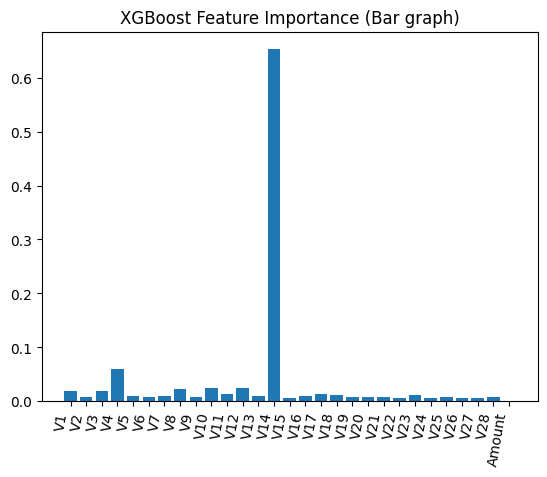

<Figure size 1200x600 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb  



# 1. Plot feature importance using xgboost.plot_importance
xgb.plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()  

# 2. Plot feature importance with your customizations
plt.bar(range(len(importance)), importance)
plt.title('XGBoost Feature Importance (Bar graph)')


plt.xticks(range(len(importance)), X.columns, rotation=80, ha='right')


plt.figure(figsize=(12, 6)) 

# Use ticker.MaxNLocator to show a limited number of labels if many features
locator = ticker.MaxNLocator(nbins=10)



<Figure size 1000x800 with 0 Axes>

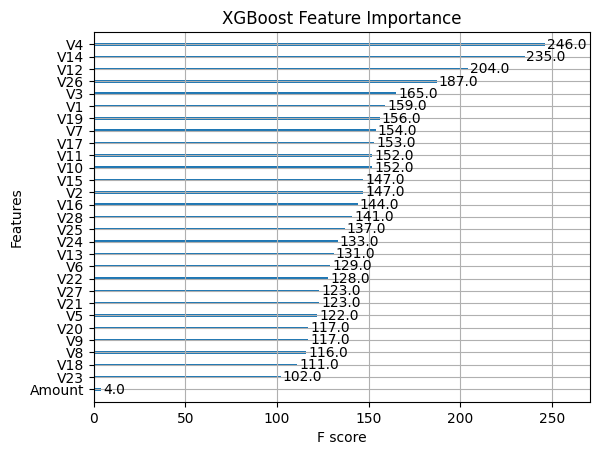

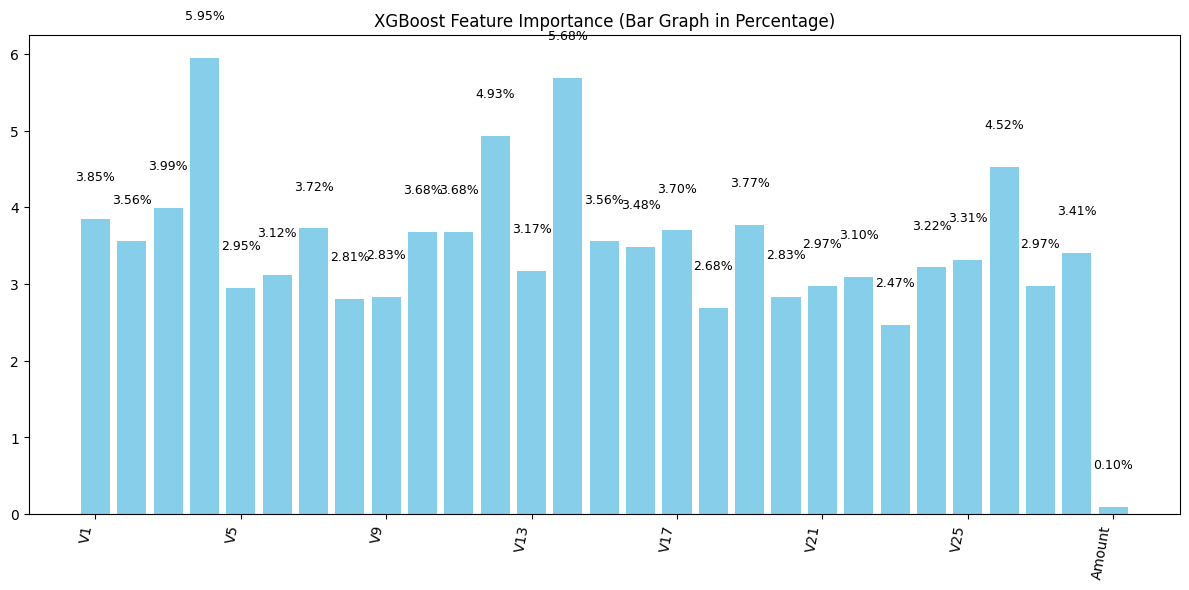

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
import numpy as np


# 1. Plot feature importance using xgboost.plot_importance
plt.figure(figsize=(10, 8)) 
xgb.plot_importance(model, importance_type='weight')
plt.title("XGBoost Feature Importance")
plt.show()  

# 2. Extract feature importance and convert to percentages
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='weight')
importance = np.array(list(importance_dict.values()))
importance_percentage = 100 * importance / np.sum(importance)

# 3. Plot feature importance 
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_percentage)), importance_percentage, color='skyblue')
plt.title('XGBoost Feature Importance (Bar Graph in Percentage)')

# Rotate x-axis labels for better readability with many features
plt.xticks(range(len(importance_percentage)), importance_dict.keys(), rotation=80, ha='right')

# Use ticker.MaxNLocator to show a limited number of labels if many features
locator = ticker.MaxNLocator(nbins=10)
plt.gca().xaxis.set_major_locator(locator)

# Show the percentages on top of the bars
for i, v in enumerate(importance_percentage):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np


# Extract feature importance and convert to percentages
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='weight')
importance = np.array(list(importance_dict.values()))
importance_percentage = 100 * importance / np.sum(importance)

# Convert importance to a DataFrame for easier handling
importance_df = pd.DataFrame({
    'Feature': importance_dict.keys(),
    'Importance_Percentage': importance_percentage
})

features_to_keep = importance_df[importance_df['Importance_Percentage'] >= 3.5]['Feature'].tolist()

X_filtered = X[features_to_keep]

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features retained: {X_filtered.shape[1]}")
print(f"Features retained: {features_to_keep}")



Original number of features: 29
Number of features retained: 13
Features retained: ['V1', 'V2', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V15', 'V17', 'V19', 'V26']


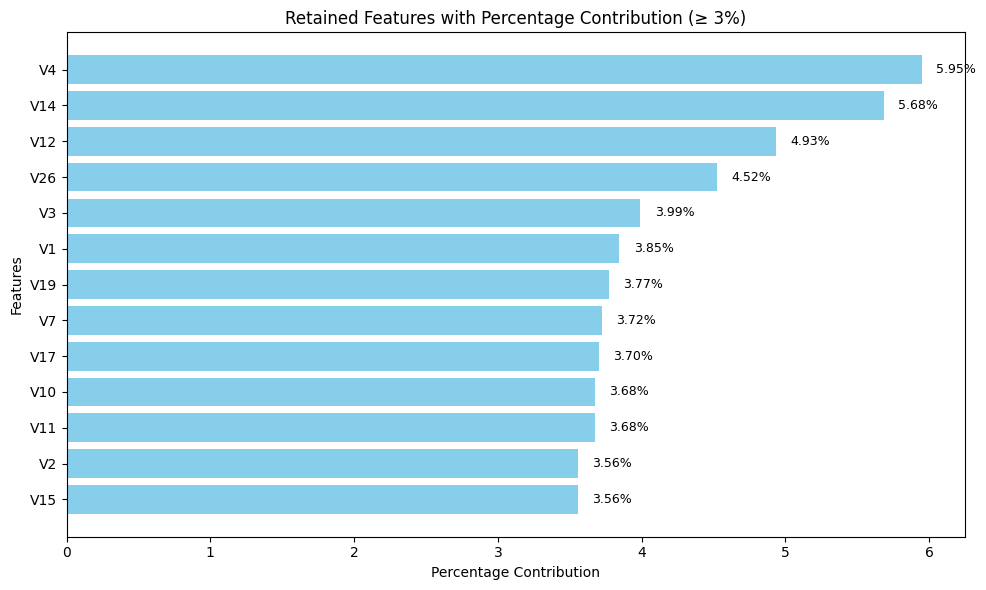

In [18]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

retained_features_df = importance_df[importance_df['Importance_Percentage'] >= 3.5]

# Sort the retained features by importance for better visualization
retained_features_df = retained_features_df.sort_values(by='Importance_Percentage', ascending=False)

# Plot the retained features with their percentage contributions
plt.figure(figsize=(10, 6))
plt.barh(retained_features_df['Feature'], retained_features_df['Importance_Percentage'], color='skyblue')

plt.xlabel('Percentage Contribution')
plt.ylabel('Features')
plt.title('Retained Features with Percentage Contribution (≥ 3%)')

for index, value in enumerate(retained_features_df['Importance_Percentage']):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [19]:

features_to_keep = importance_df[importance_df['Importance_Percentage'] >= 3.5]['Feature'].tolist()

features_to_drop = [feature for feature in da.columns if feature not in features_to_keep and feature != 'Class']

da_filtered = da.drop(columns=features_to_drop)

print(f"Original number of features: {da.shape[1]}")
print(f"Number of features retained: {da_filtered.shape[1]}")
print(f"Retained features: {features_to_keep}")
print(f"Dropped features: {features_to_drop}")


Original number of features: 30
Number of features retained: 14
Retained features: ['V1', 'V2', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V15', 'V17', 'V19', 'V26']
Dropped features: ['V5', 'V6', 'V8', 'V9', 'V13', 'V16', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V27', 'V28', 'Amount']


Data visualization

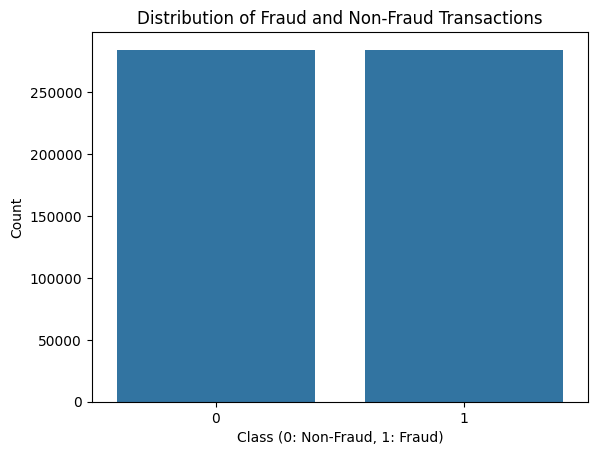

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot for class distribution
sns.countplot(x='Class', data=da)
plt.title('Distribution of Fraud and Non-Fraud Transactions')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()


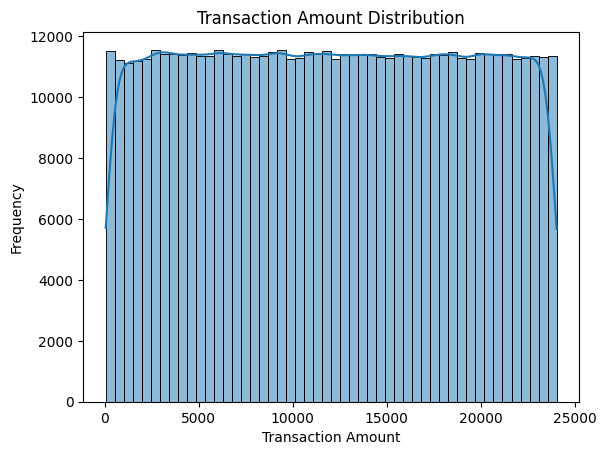

In [21]:
# Histogram of transaction amounts
sns.histplot(da['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


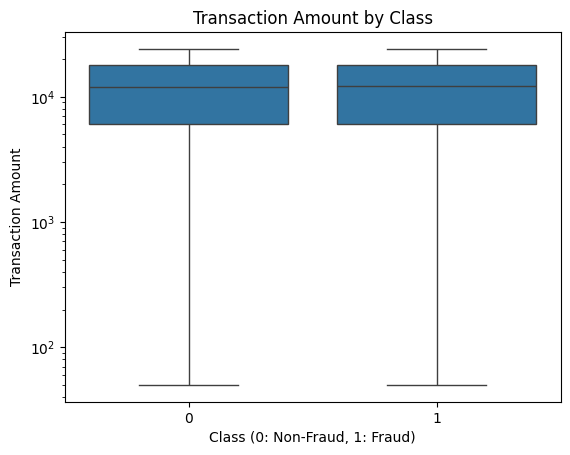

In [22]:
# Boxplot of transaction amounts by class
sns.boxplot(x='Class', y='Amount', data=da)
plt.title('Transaction Amount by Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Transaction Amount')
plt.yscale('log')
plt.show()


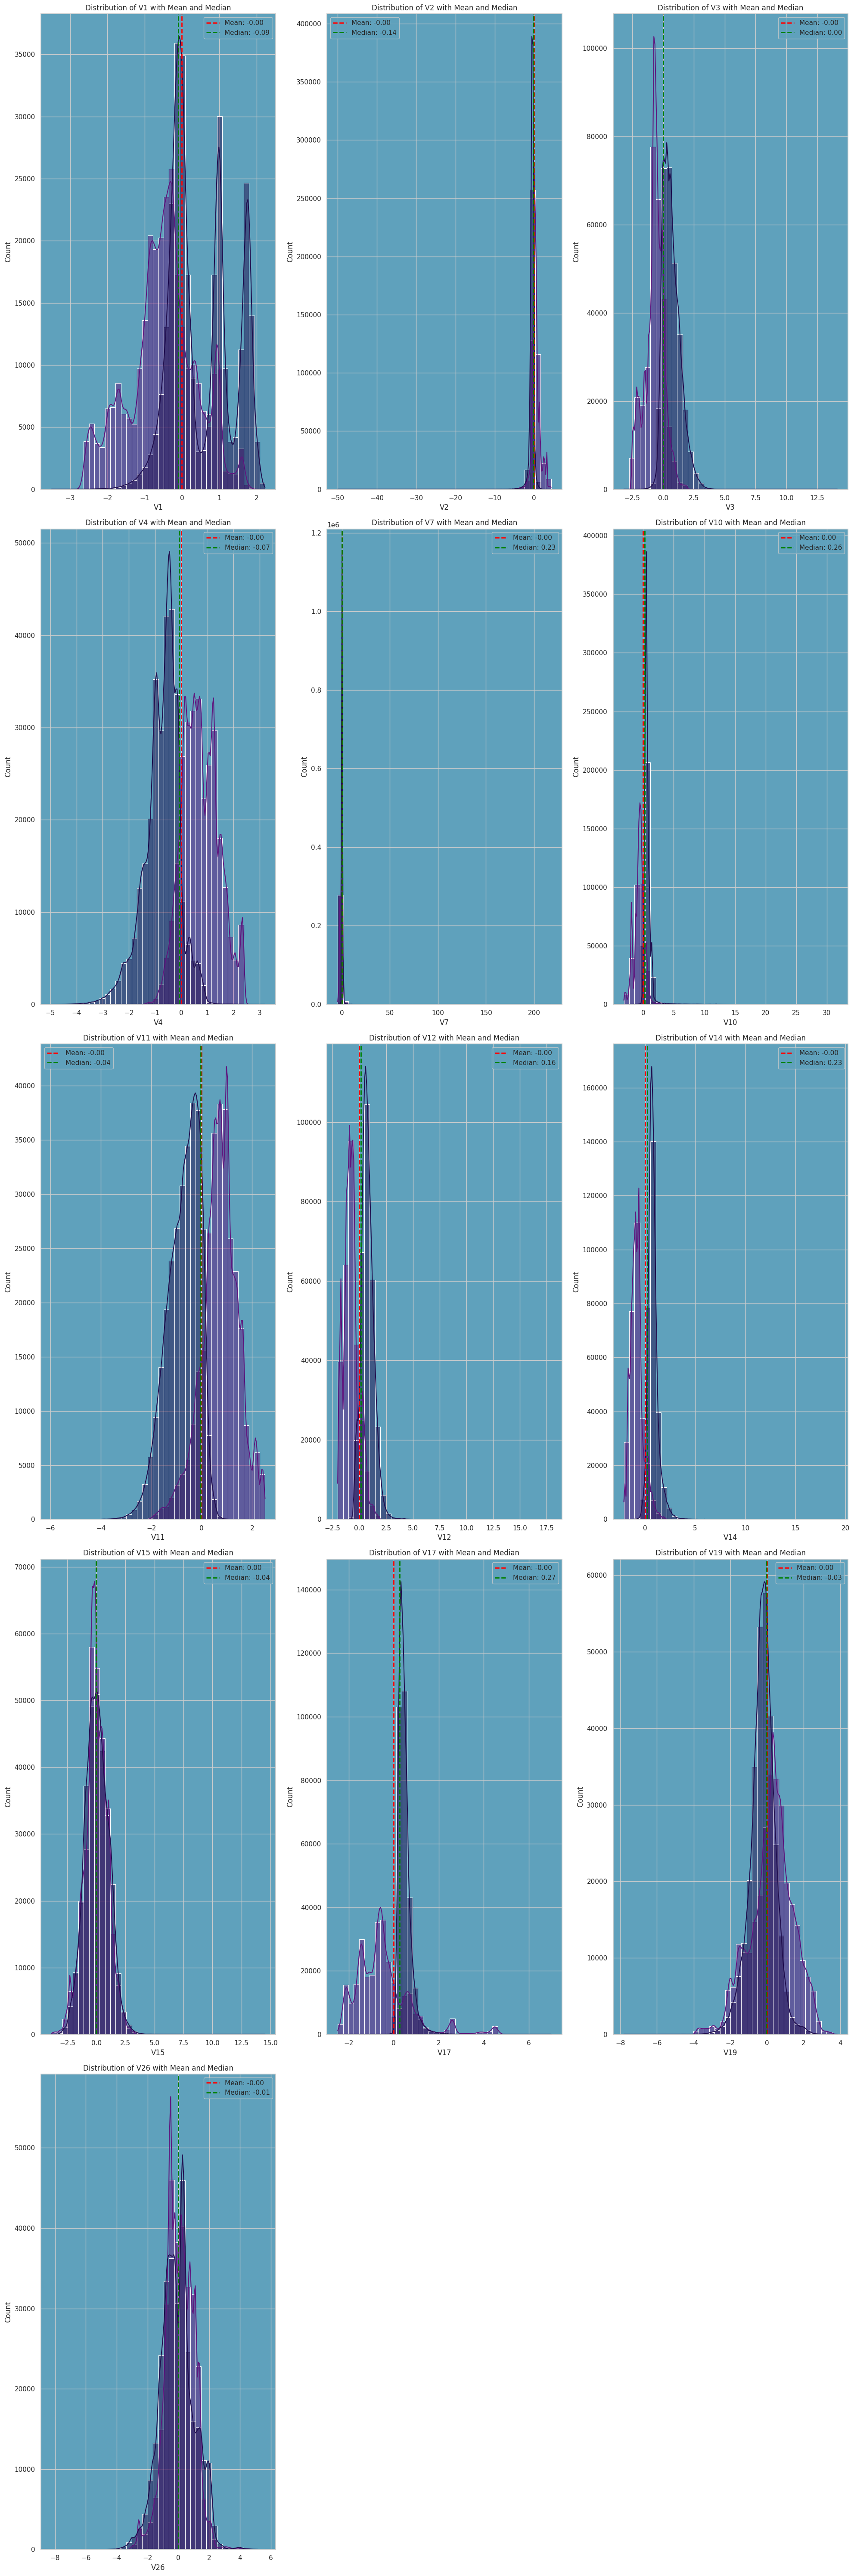

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_subplots(columns, hue, theme_style, theme_rc, palette, figsize=(15, 10)):
    sns.set_theme(style=theme_style, rc=theme_rc)

    columns = [col for col in columns if col != hue]

    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    axes = axes.flatten()

    plot_index = 0
    for col in columns:
        sns.histplot(data=da_filtered, x=col, hue=hue, bins=40, palette=palette, edgecolor='white', kde=True, ax=axes[plot_index])

        mean_value = da_filtered[col].mean()
        median_value = da_filtered[col].median()

    
        axes[plot_index].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        axes[plot_index].axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
        axes[plot_index].set_title(f'Distribution of {col} with Mean and Median')
        axes[plot_index].set_xlabel(col)
        axes[plot_index].set_ylabel('Count')
        axes[plot_index].legend()

        plot_index += 1

    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

columns = da_filtered.columns.to_list()
palette = sns.color_palette("magma")

create_subplots(columns=columns, hue='Class',
                theme_style='whitegrid', theme_rc={"axes.facecolor": "#5fa1bc"},
                palette=palette, figsize=(20, 60))


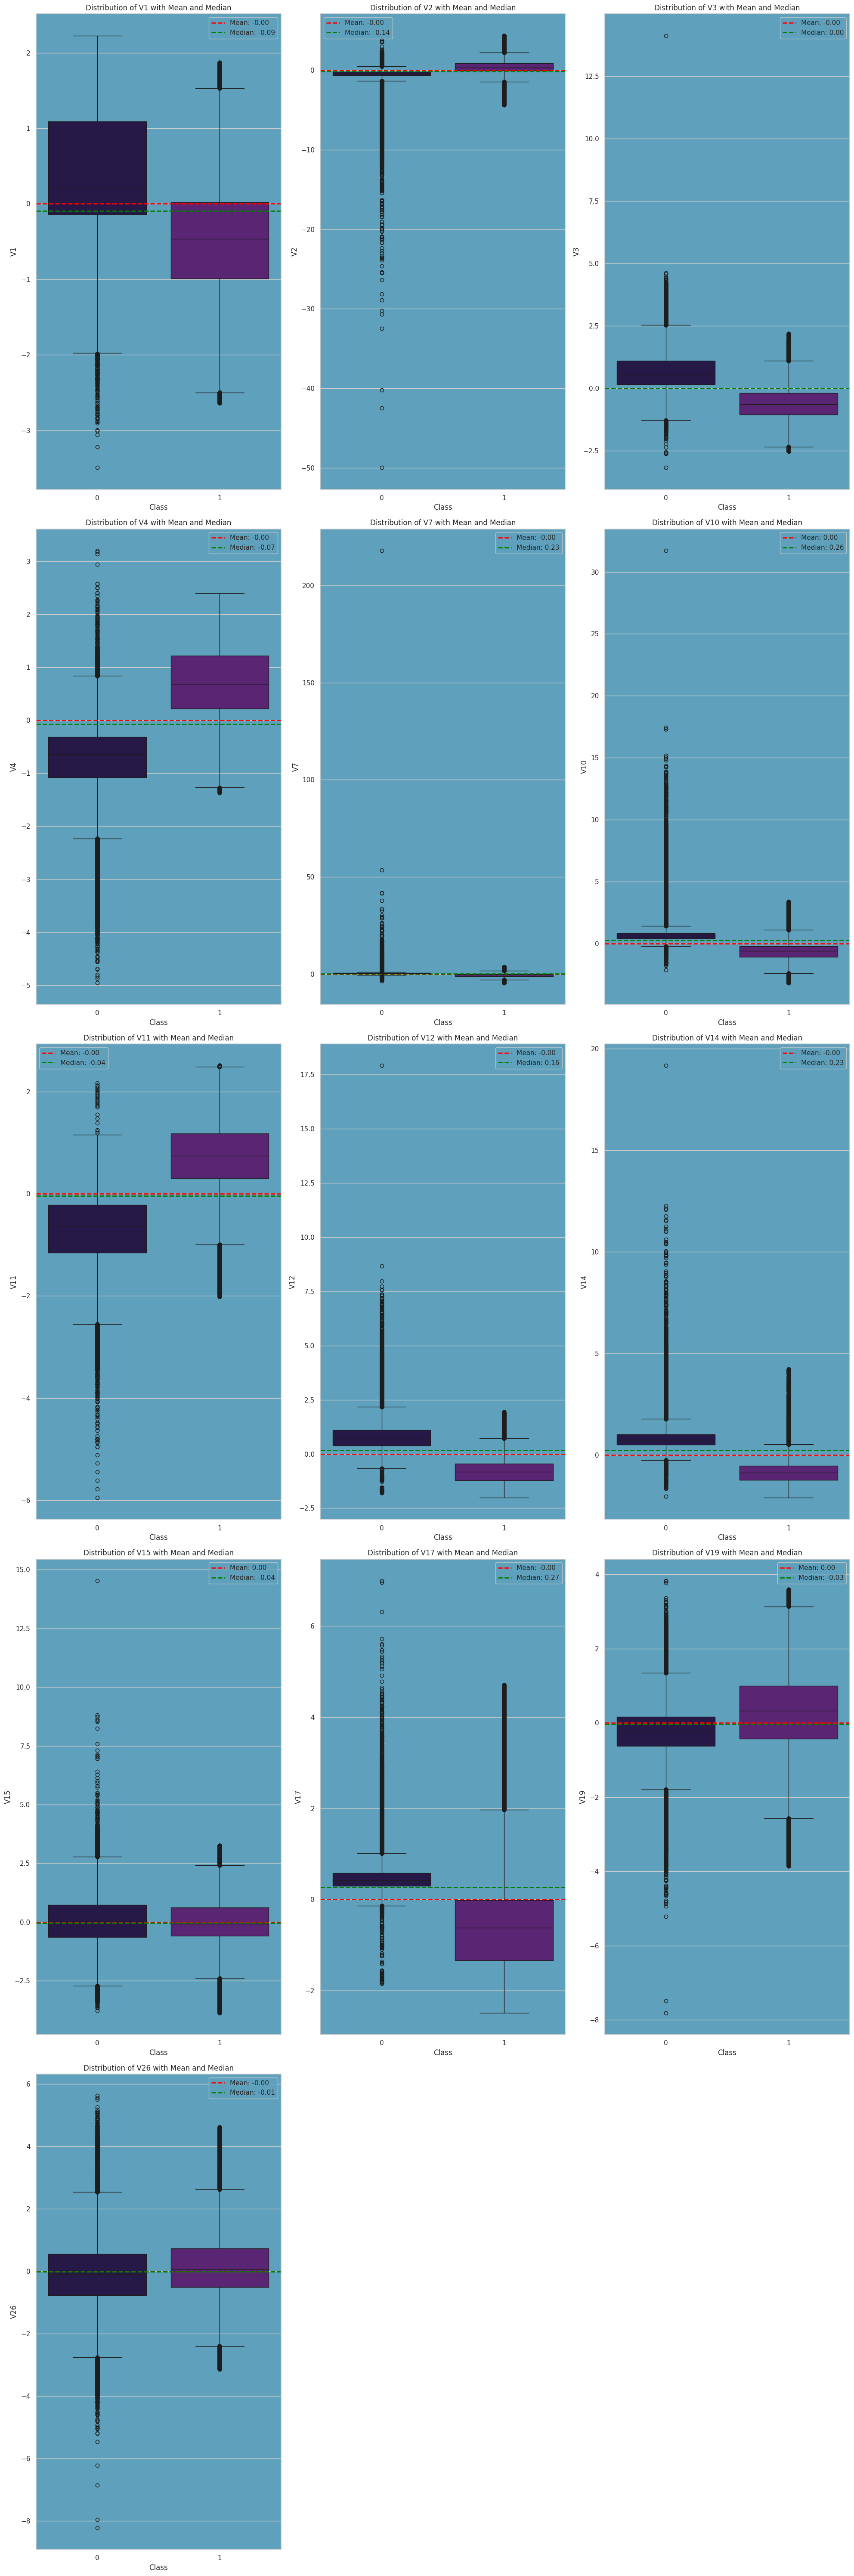

In [24]:
def create_boxplot_subplots(df, columns, hue, theme_style, theme_rc, palette, figsize=(15, 10)):
    sns.set_theme(style=theme_style, rc=theme_rc)

    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    axes = axes.flatten()

    plot_index = 0
    for col in columns:
        if col == hue:
            continue

        sns.boxplot(data=df, x=hue, y=col, palette=palette, ax=axes[plot_index])

        mean_value = df[col].mean()
        median_value = df[col].median()

        axes[plot_index].axhline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        axes[plot_index].axhline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

        axes[plot_index].set_title(f'Distribution of {col} with Mean and Median')
        axes[plot_index].set_xlabel(hue)
        axes[plot_index].set_ylabel(col)
        axes[plot_index].legend()

        plot_index += 1

    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

columns = da_filtered.columns.to_list()
palette = sns.color_palette("magma")

create_boxplot_subplots(df=da, columns=columns, hue='Class',
                        theme_style='whitegrid', theme_rc={"axes.facecolor": "#5fa1bc"},
                        palette=palette, figsize=(20, 60))

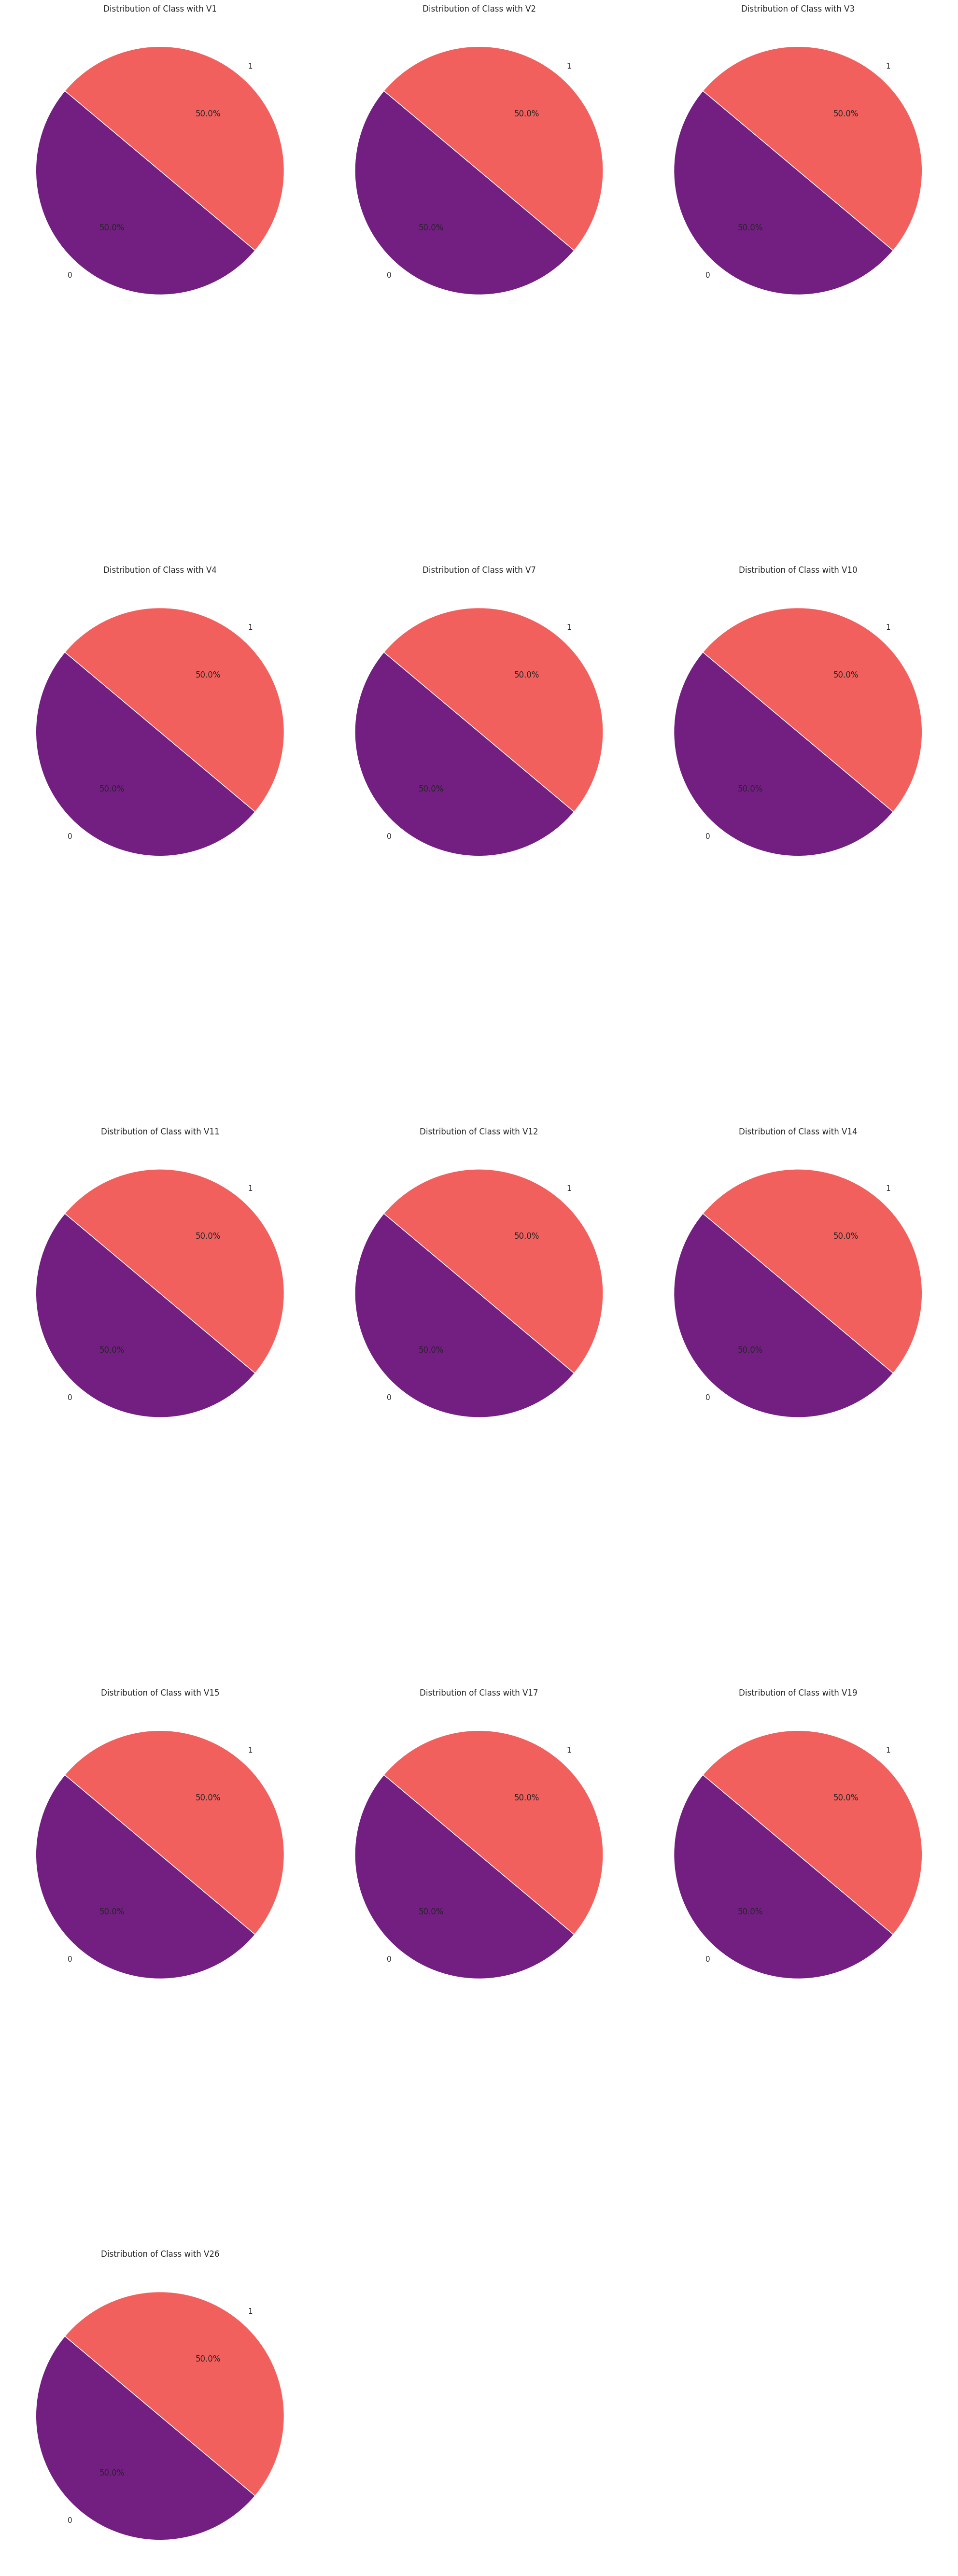

In [25]:
def create_piechart_subplots(df, columns, hue, theme_style, theme_rc, figsize=(15, 10)):
    sns.set_theme(style=theme_style, rc=theme_rc)

    num_columns = len(columns) - 1
    num_rows = (num_columns + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    axes = axes.flatten()

    plot_index = 0
    for col in columns:
        if col == hue:
            continue

       
        class_counts = df[hue].value_counts()
        axes[plot_index].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("magma", len(class_counts)))
        axes[plot_index].set_title(f'Distribution of {hue} with {col}')
        plot_index += 1

    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

columns = da_filtered.columns.to_list()
hue = columns[-1]

create_piechart_subplots(df=da, columns=columns, hue=hue,
                         theme_style='whitegrid', theme_rc={"axes.facecolor": "#5fa1bc"},
                         figsize=(20, 60))

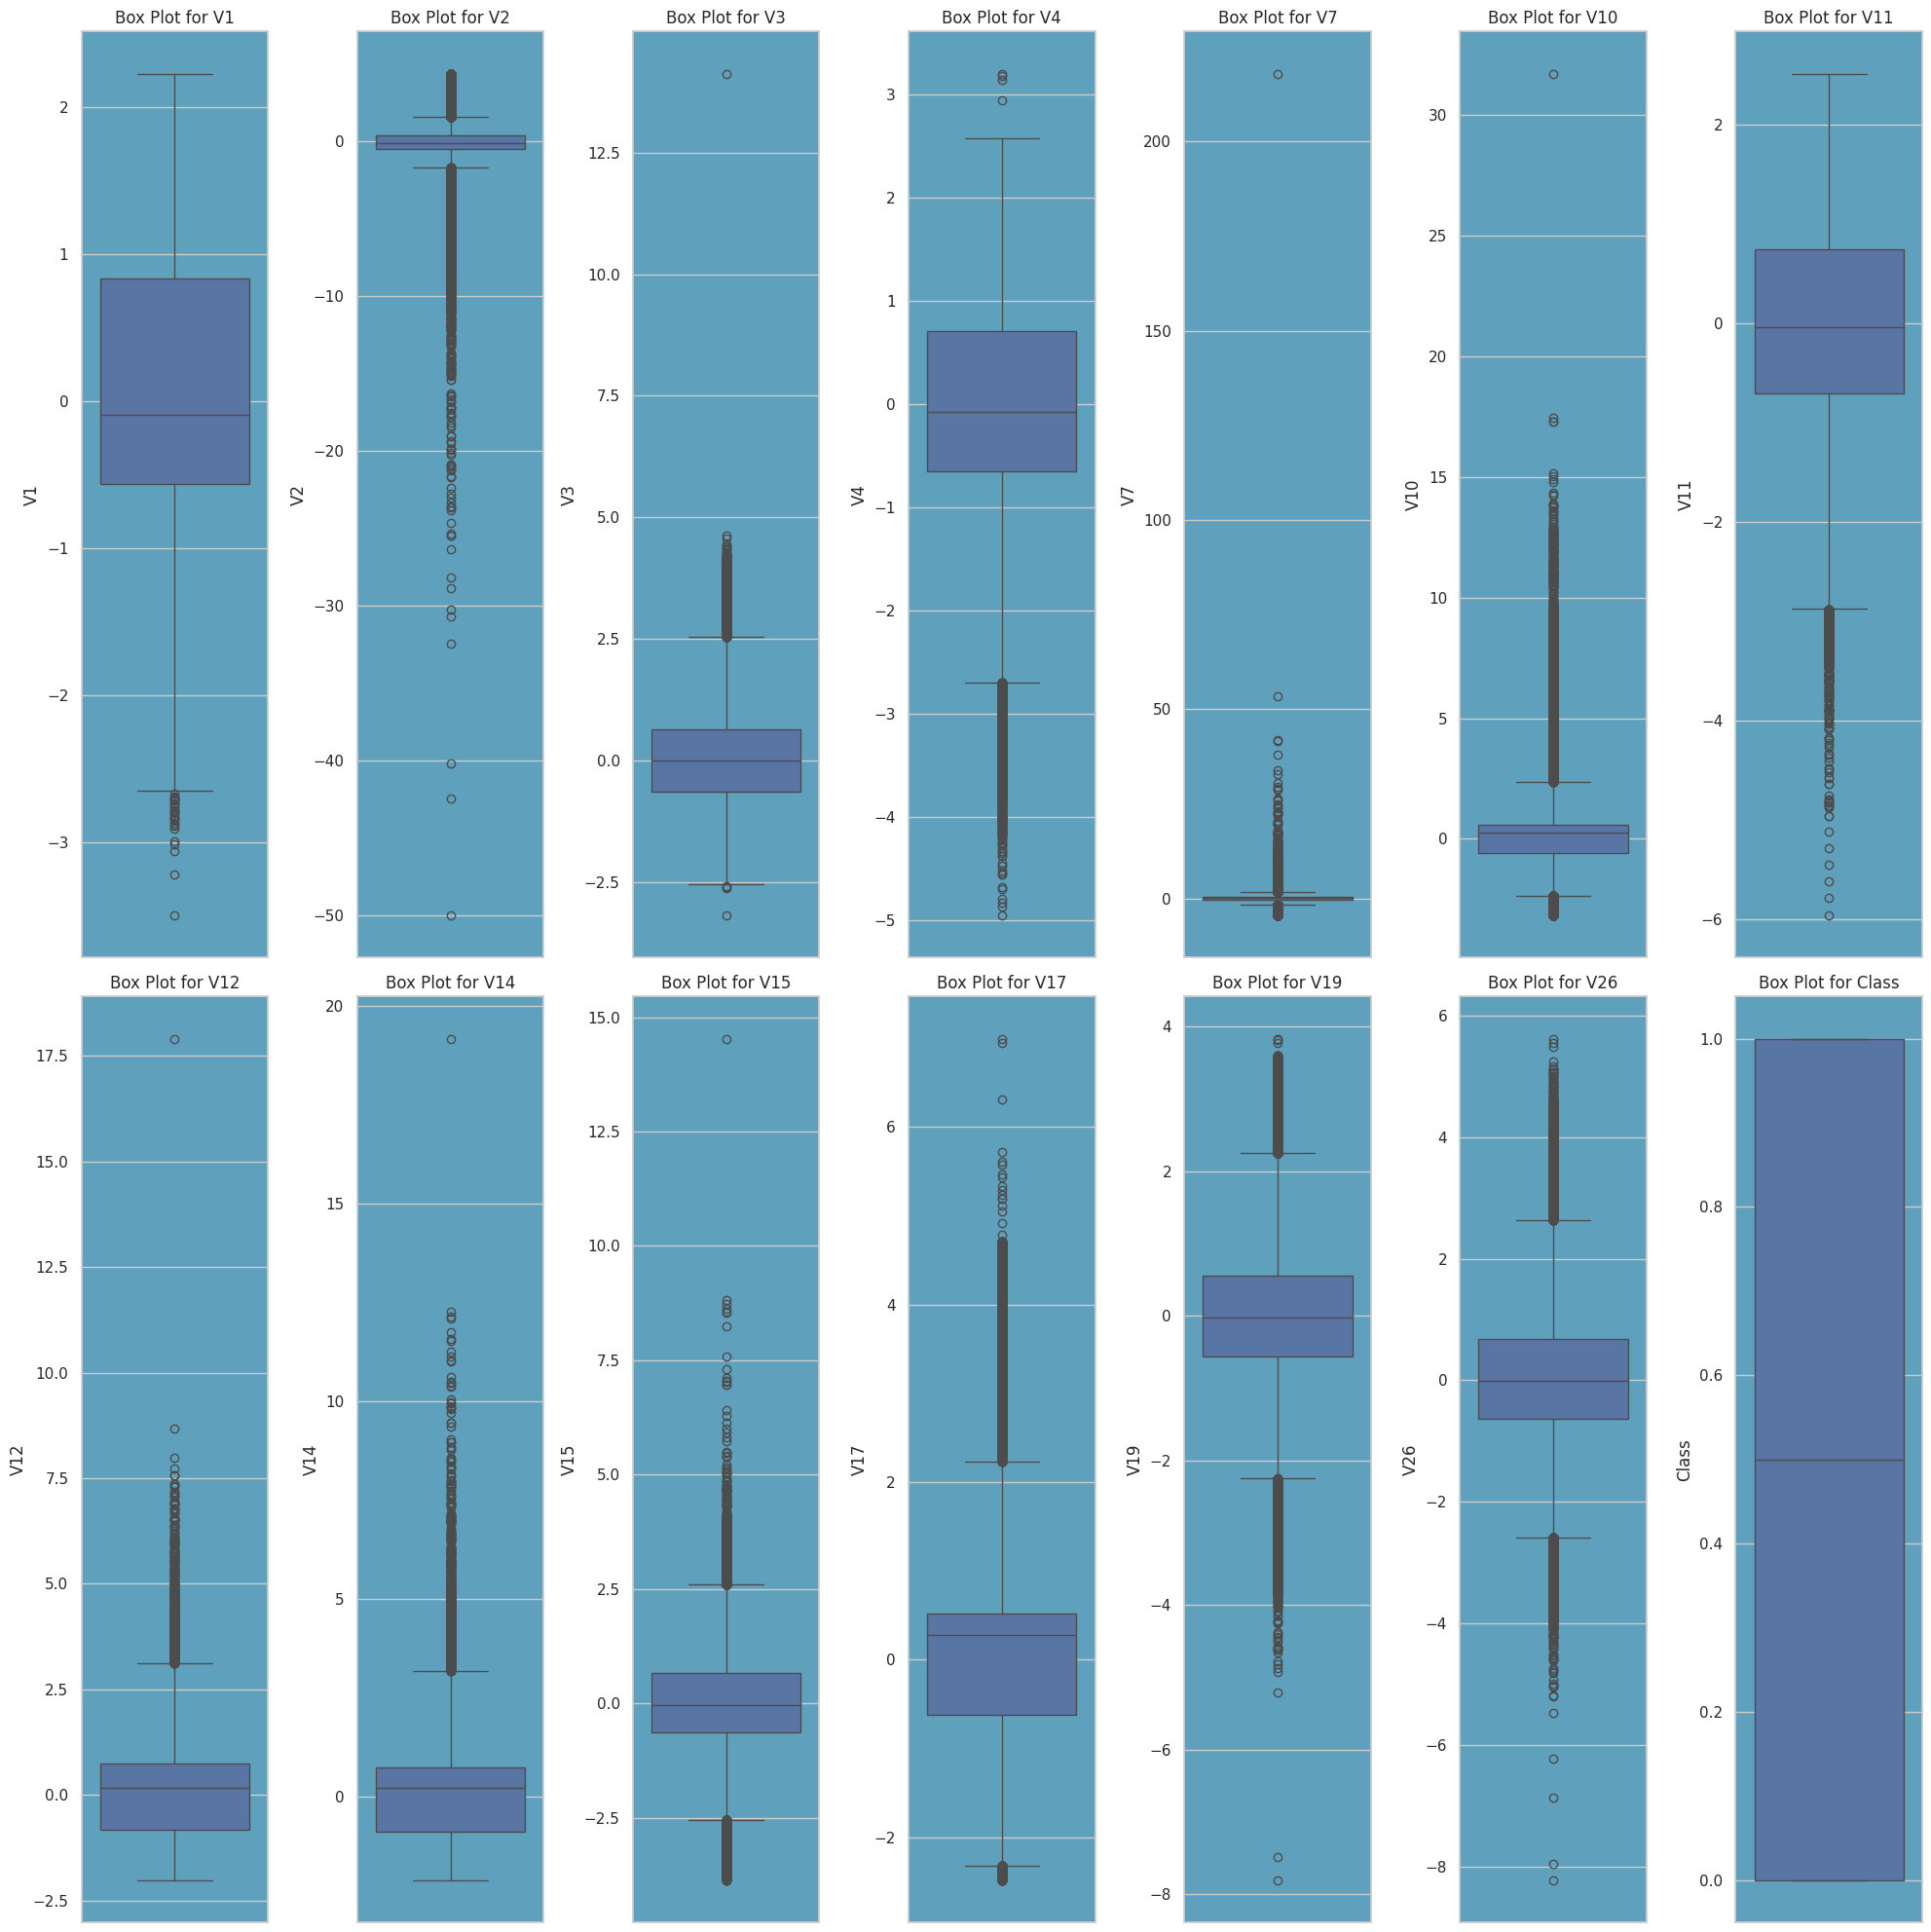

In [26]:
# Checking outliers
fig, axes = plt.subplots(2,7,figsize = (20,20))
axes = axes.flatten()
for i, column in enumerate(da_filtered.columns):
    sns.boxplot(da[column], ax= axes[i])
    axes[i].set_title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

Since the mean is equal to zero and the standard deviation is one therefore all independent variable are scaled except amount feature

In [27]:
# Correlation
correlation_matrix = da_filtered.corr()
correlation_matrix

,V1,V2,V3,V4,V7,V10,V11,V12,V14,V15,V17,V19,V26,Class
V1,1.000000,-0.561184,0.484499,-0.498963,0.573381,0.599108,-0.525797,0.580715,0.494427,0.046002,0.605799,-0.377803,0.009281,-0.505761
V2,-0.561184,1.000000,-0.627810,0.579638,-0.694022,-0.621798,0.558863,-0.574935,-0.523294,-0.161325,-0.495836,0.208821,0.012219,0.491878
V3,0.484499,-0.627810,1.000000,-0.687726,0.634336,0.707676,-0.688436,0.705497,0.673179,0.098516,0.578223,-0.314396,-0.052056,-0.682095
V4,-0.498963,0.579638,-0.687726,1.000000,-0.588648,-0.712839,0.708642,-0.722597,-0.714847,-0.098627,-0.532786,0.269842,0.136679,0.735981
V7,0.573381,-0.694022,0.634336,-0.588648,1.000000,0.678004,-0.587660,0.603318,0.535612,0.135939,0.655755,-0.372270,-0.006488,-0.491234
V10,0.599108,-0.621798,0.707676,-0.712839,0.678004,1.000000,-0.713066,0.736783,0.698939,0.111051,0.649149,-0.375080,-0.053684,-0.673665
V11,-0.525797,0.558863,-0.688436,0.708642,-0.587660,-0.713066,1.000000,-0.744642,-0.762322,-0.058089,-0.601924,0.346170,0.133635,0.724278
V12,0.580715,-0.574935,0.705497,-0.722597,0.603318,0.736783,-0.744642,1.000000,0.783878,0.041208,0.658739,-0.368161,-0.114272,-0.768579
V14,0.494427,-0.523294,0.673179,-0.714847,0.535612,0.698939,-0.762322,0.783878,1.000000,0.010011,0.552428,-0.315192,-0.142472,-0.805669
V15,0.046002,-0.161325,0.098516,-0.098627,0.135939,0.111051,-0.058089,0.041208,0.010011,1.000000,0.031912,0.185638,0.047833,-0.037948


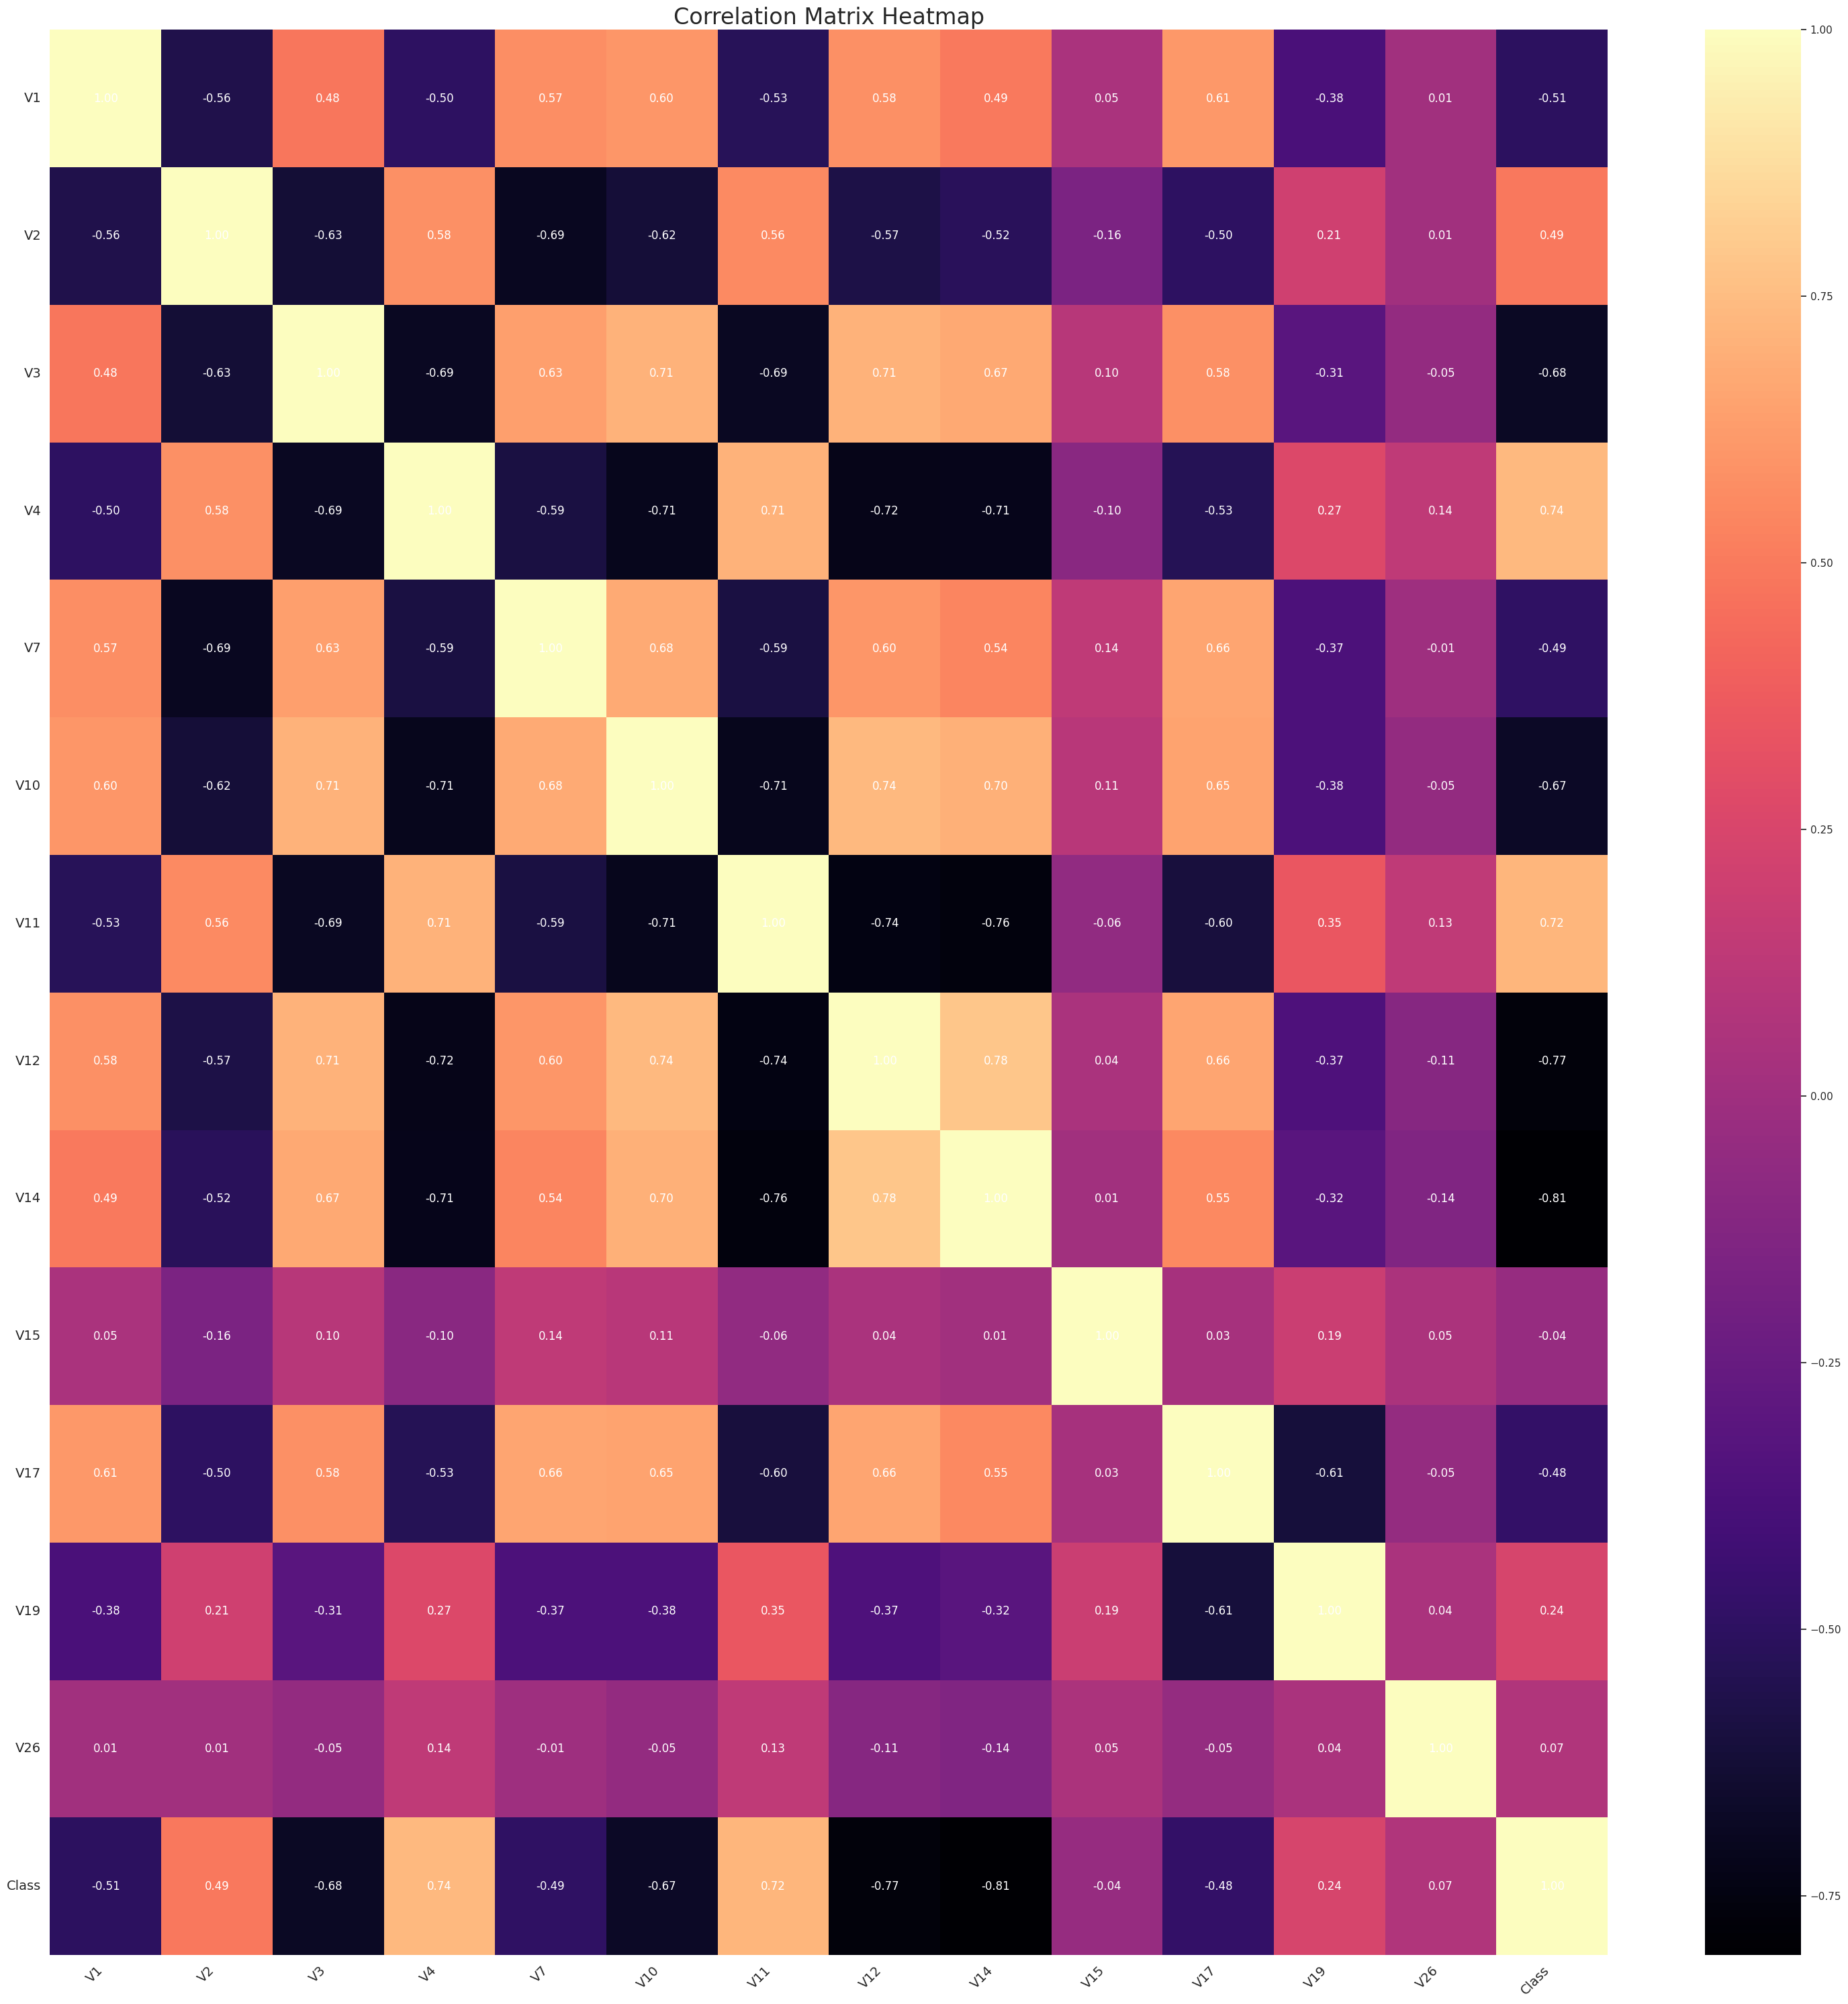

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = da_filtered.corr()

plt.figure(figsize=(30, 30))

heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt='.2f', annot_kws={"size": 12, "color": "white"})

plt.title('Correlation Matrix Heatmap', size=24)
plt.xticks(rotation=45, ha='right', size=14)
plt.yticks(rotation=0, size=14)

plt.tight_layout()
plt.show()


In [29]:
#Check data imbalance
da_filtered['Class'].value_counts()

,count
Class,
0,284315
1,284315


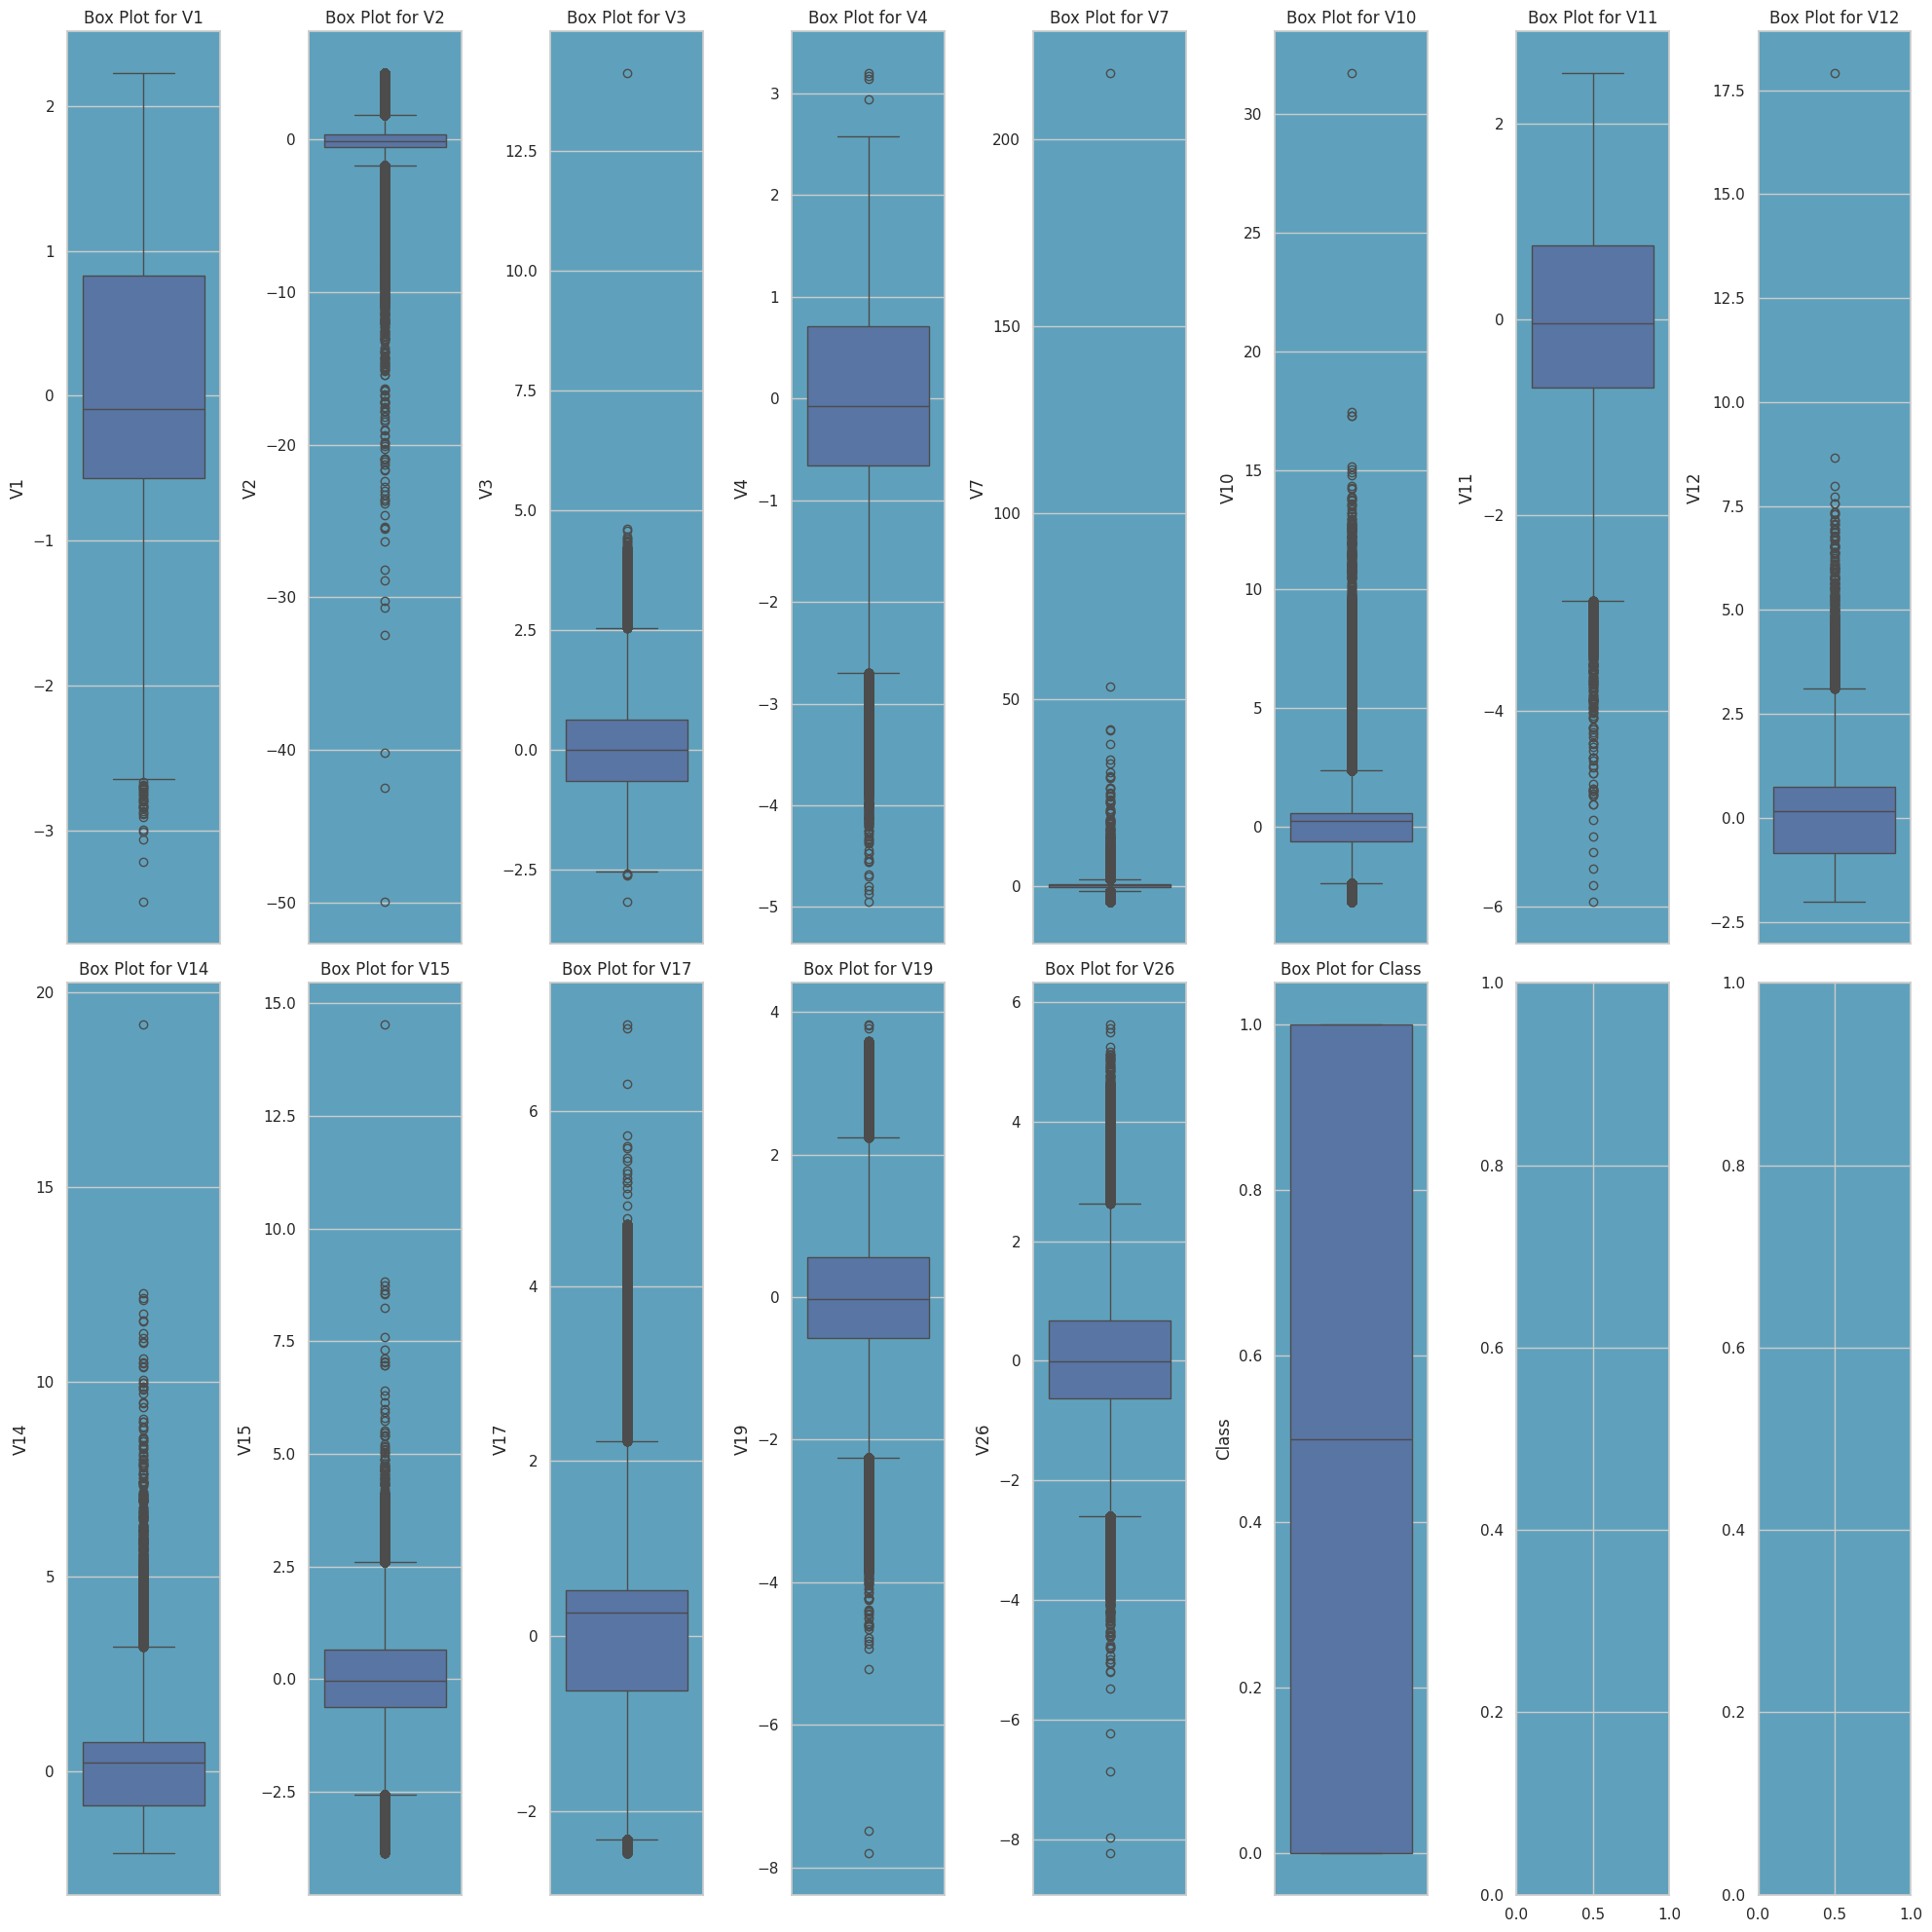

In [30]:
# Check outliers
fig, axes = plt.subplots(2,8,figsize = (20,20))
axes = axes.flatten()
for i, column in enumerate(da_filtered.columns):
    sns.boxplot(da_filtered[column], ax= axes[i])
    axes[i].set_title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

What I have observed is that there are a lot of outliers and I need to handle them. With the use of isolationForest I will be able to detect anomalies.

In [31]:
# check the scale of the dataframe
df_describe = pd.DataFrame(da_filtered.describe())
df_describe

,V1,V2,V3,V4,V7,V10,V11,V12,V14,V15,V17,V19,V26,Class
count,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.0
mean,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,-3.198898e-17,1.991314e-16,-1.183592e-16,-5.758017e-17,-4.078595e-17,2.649087e-17,-3.398829e-17,2.479146e-17,-7.497417e-18,0.5
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.5
min,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-4.351839e+00,-3.163276e+00,-5.954723e+00,-2.020399e+00,-2.107417e+00,-3.861813e+00,-2.484938e+00,-7.804988e+00,-8.226969e+00,0.0
25%,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.835329e-01,-5.901008e-01,-7.014495e-01,-8.311331e-01,-8.732057e-01,-6.212485e-01,-6.194913e-01,-5.653082e-01,-6.318948e-01,0.0
50%,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,2.333659e-01,2.626145e-01,-4.104986e-02,1.620521e-01,2.305011e-01,-3.925566e-02,2.716407e-01,-2.597869e-02,-1.189208e-02,0.5
75%,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,5.259548e-01,5.924603e-01,7.477730e-01,7.446723e-01,7.518216e-01,6.654065e-01,5.182242e-01,5.601164e-01,6.728879e-01,1.0
max,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,2.178730e+02,3.172271e+01,2.513573e+00,1.791356e+01,1.916954e+01,1.453220e+01,6.994124e+00,3.831672e+00,5.623285e+00,1.0


In [32]:
#Split the data
x = da_filtered.drop(columns= 'Class')
y= da_filtered[['Class']]

In [33]:
# run Isolation forest model
from sklearn.ensemble import IsolationForest
is_forest = IsolationForest(n_estimators= 300, max_samples= 100000, contamination = 0.2, bootstrap= True, random_state = 0)
outlier_prediction = is_forest.fit_predict(x)
outlier_prediction

array([ 1,  1, -1, ...,  1,  1,  1])

In [34]:
#Get indices of the outliers
no_of_outliers = []
for i in range(len(outlier_prediction)):
    if outlier_prediction[i] == -1:
        no_of_outliers.append(i)
len(no_of_outliers), no_of_outliers

(113726,
 [2,
  43,
  46,
  48,
  69,
  82,
  83,
  85,
  96,
  116,
  132,
  140,
  146,
  150,
  161,
  164,
  174,
  180,
  181,
  190,
  210,
  211,
  212,
  218,
  225,
  236,
  238,
  241,
  251,
  282,
  288,
  290,
  306,
  351,
  361,
  362,
  370,
  401,
  450,
  455,
  468,
  510,
  526,
  529,
  533,
  547,
  558,
  564,
  585,
  601,
  608,
  631,
  641,
  647,
  664,
  665,
  667,
  699,
  706,
  707,
  718,
  723,
  760,
  764,
  768,
  780,
  795,
  807,
  827,
  838,
  841,
  860,
  862,
  865,
  878,
  883,
  897,
  901,
  913,
  917,
  952,
  956,
  958,
  962,
  970,
  971,
  980,
  983,
  986,
  992,
  997,
  1009,
  1026,
  1027,
  1030,
  1047,
  1058,
  1064,
  1068,
  1078,
  1086,
  1087,
  1089,
  1114,
  1143,
  1158,
  1165,
  1195,
  1218,
  1258,
  1313,
  1322,
  1346,
  1356,
  1359,
  1361,
  1364,
  1372,
  1388,
  1420,
  1425,
  1437,
  1461,
  1480,
  1500,
  1507,
  1515,
  1518,
  1535,
  1550,
  1567,
  1576,
  1579,
  1608,
  1620,
  1632,
  16

In [35]:
#Anomaly score
anomaly_score = (is_forest.decision_function(x))
anomaly_score

array([ 0.02007878,  0.04679034, -0.01868041, ...,  0.04199519,
        0.02871151,  0.02800089])

In [36]:
#Set a threshold of 10%
anomaly_score = -1*anomaly_score
percentile_threshold = np.percentile(anomaly_score, 90)
percentile_threshold

0.024857128271755305

In [37]:
#Disply anomaly score
anomaly_score

array([-0.02007878, -0.04679034,  0.01868041, ..., -0.04199519,
       -0.02871151, -0.02800089])

In [38]:
#Filter anomalies using threshold
outlier_threshold = np.where(anomaly_score>= percentile_threshold)[0]
outlier_threshold

array([    69,     82,     83, ..., 568603, 568618, 568620])

In [39]:
# Display number of outliers
len(outlier_threshold)

56863

In [41]:
# drop the outliers
df = da_filtered.copy(deep= True)
df.drop(index= outlier_threshold, inplace= True)

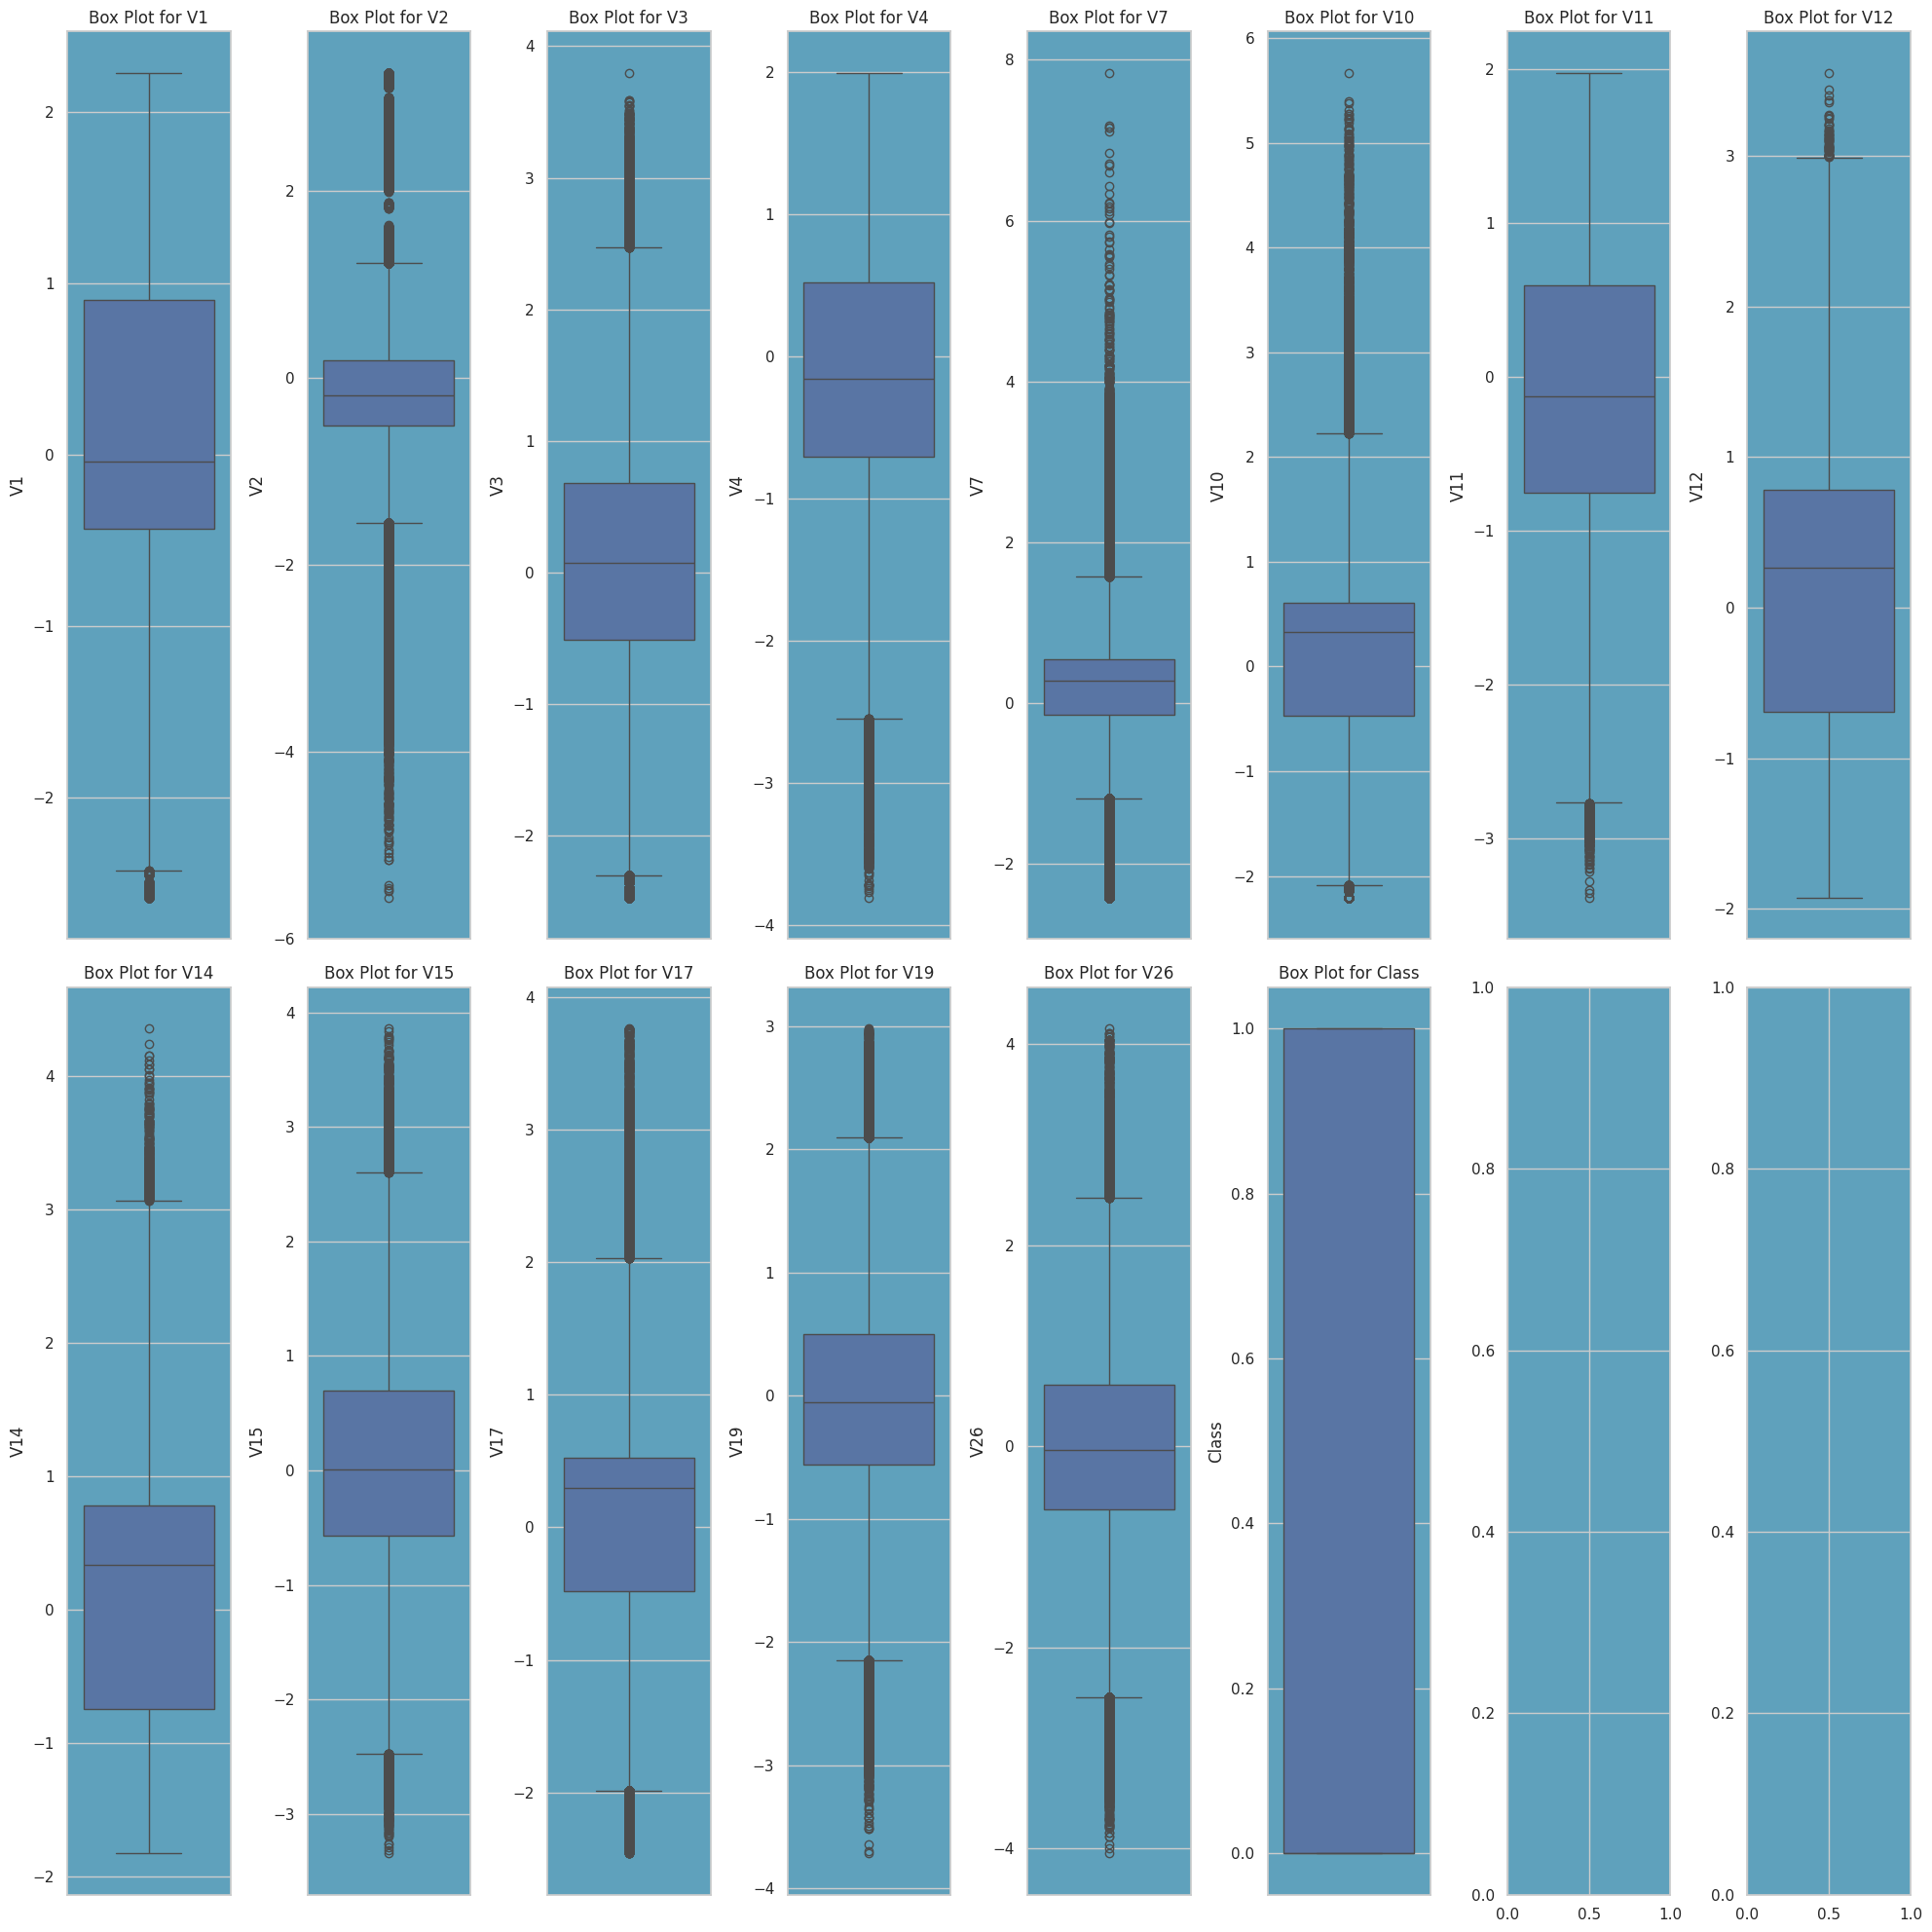

In [42]:
# Check the outliers
fig, axes = plt.subplots(2,8,figsize = (20,20))
axes = axes.flatten()
for i, column in enumerate(df.columns):
    sns.boxplot(df[column], ax= axes[i])
    axes[i].set_title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

In [43]:
#Check the imbalance
df['Class'].value_counts()

,count
Class,
0,273620
1,238147


In [44]:
# divide the data into independent and dependent variables
x=  df.drop(columns= 'Class')
y= df[['Class']]

In [45]:
len(x), len(y)

(511767, 511767)

Modelling

Logistic Regression Model

In [46]:
#Implementing a logisitic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score   , precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
lr_model = LogisticRegression(random_state= 0)
parameters = {'penalty': ['l1', 'l2'], 'C': [30,40,50], 'solver' : ['saga', 'lbfgs']}
lr_grid_model = GridSearchCV(estimator= lr_model, param_grid = parameters, cv = 5, scoring= 'recall',)
lr_grid_model.fit(x,y)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [30, 40, 50], 'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'lbfgs']},
             scoring='recall')

In [47]:
#Outcomes of the logistic regression model
lr_grid_model.best_score_, lr_grid_model.best_params_, lr_grid_model.cv_results_

(0.9329363728884505,
 {'C': 30, 'penalty': 'l2', 'solver': 'lbfgs'},
 {'mean_fit_time': array([3.65396953, 0.02143559, 3.05595579, 0.72377586, 3.95039396,
         0.02334709, 3.17696433, 0.70341234, 4.75534663, 0.02189326,
         2.89606395, 0.69063869]),
  'std_fit_time': array([0.43491926, 0.00322377, 0.45433451, 0.03128212, 0.54893171,
         0.00245849, 0.49031967, 0.03959623, 1.8633986 , 0.00370152,
         0.4885608 , 0.03586829]),
  'mean_score_time': array([0.07300358, 0.        , 0.06385951, 0.065802  , 0.07431536,
         0.        , 0.06209388, 0.06555219, 0.090134  , 0.        ,
         0.06205688, 0.06387501]),
  'std_score_time': array([0.02228629, 0.        , 0.00424373, 0.00785306, 0.02128318,
         0.        , 0.0016905 , 0.00317386, 0.03113398, 0.        ,
         0.00268337, 0.00331636]),
  'param_C': masked_array(data=[30, 30, 30, 30, 40, 40, 40, 40, 50, 50, 50, 50],
               mask=[False, False, False, False, False, False, False, False,
           

In [48]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

# Best estimator after GridSearchCV
best_model = lr_grid_model.best_estimator_

y_pred = best_model.predict(x)

accuracy = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
precision = precision_score(y, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))


Accuracy: 0.9586
Recall: 0.9330
Precision: 0.9771

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    273620
           1       0.98      0.93      0.95    238147

    accuracy                           0.96    511767
   macro avg       0.96      0.96      0.96    511767
weighted avg       0.96      0.96      0.96    511767


Confusion Matrix:
[[268410   5210]
 [ 15959 222188]]


Random Forest Model

In [49]:
da_filtered = da_filtered.dropna()

X = da_filtered.drop(columns=['Class'])
y = da_filtered['Class']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

rf_model = RandomForestClassifier(random_state=0, bootstrap=True)

# Define the hyperparameters for GridSearchCV
parameters = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [6, 9, 10],
    'max_samples': [18000, 20000]
}

rf_grid_model = GridSearchCV(estimator=rf_model, param_grid=parameters, cv=5, scoring='recall')

rf_grid_model.fit(X, y)

print(f"Best Parameters: {rf_grid_model.best_params_}")
print(f"Best Recall Score: {rf_grid_model.best_score_:.4f}")


X shape: (568630, 13)
y shape: (568630,)
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_samples': 20000}
Best Recall Score: 0.9680


In [ ]:
import pickle

# Save the stacking model as a pickle file
filename = 'random_forest_model.pkl'
pickle.dump(rf_grid_model, open(filename, 'wb'))

print(f"random forest model saved as {filename}")


random forest model saved as random_forest_model.pkl


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

X = da_filtered.drop(columns=['Class'])
y = da_filtered['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

best_rf_model = rf_grid_model.best_estimator_
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9818
Recall: 0.9685
Precision: 0.9951

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     56724
           1       1.00      0.97      0.98     57002

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726



Ensemble model

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report


In [52]:

X = da_filtered.drop(columns=['Class'])
y = da_filtered['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [53]:
logistic = LogisticRegression(random_state=0)
svm = SVC(probability=True, random_state=0)
random_forest = RandomForestClassifier(random_state=0)

In [55]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Simplify base models
logistic = LogisticRegression(max_iter=100)  
svm = SVC(kernel='linear', probability=True, max_iter=200) 
random_forest = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1)  

# Define the stacking ensemble
estimators = [
    ('logistic', logistic),
    ('svm', svm),
    ('random_forest', random_forest)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    cv=5
)

# Fit the model
stacking_model.fit(X_train_scaled, y_train)


StackingClassifier(cv=5,
                   estimators=[('logistic', LogisticRegression()),
                               ('svm',
                                SVC(kernel='linear', max_iter=200,
                                    probability=True)),
                               ('random_forest',
                                RandomForestClassifier(max_depth=5,
                                                       n_estimators=50,
                                                       n_jobs=-1))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [57]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(stacking_model, X_train_scaled, y_train, cv=5, scoring='recall')
print(f"Cross-validation recall scores: {cv_scores}")
print(f"Mean cross-validation recall: {cv_scores.mean()}")


Cross-validation recall scores: [0.94423914 0.94094098 0.94219475 0.94019312 0.93885003]
Mean cross-validation recall: 0.9412836068414903


In [58]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_test_pred = stacking_model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Set Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{conf_matrix}")


Test Set Accuracy: 0.9625151680354537
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56724
           1       0.98      0.94      0.96     57002

    accuracy                           0.96    113726
   macro avg       0.96      0.96      0.96    113726
weighted avg       0.96      0.96      0.96    113726

Confusion Matrix:
[[55773   951]
 [ 3312 53690]]


Model performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import plotly.graph_objects as go

performance_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

models = {
    'Logistic Regression': lr_grid_model,
    'Random Forest': rf_grid_model,
    'Ensemble Stacking': stacking_model
}

# Evaluate each model and store the metrics
for model_name, model in models.items():
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='binary')
    recall = recall_score(y_test, y_test_pred, average='binary')
    f1 = f1_score(y_test, y_test_pred, average='binary')
    
    # Append the results to the dictionary
    performance_metrics['Model'].append(model_name)
    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1-Score'].append(f1)

fig = go.Figure()

# Loop through each metric to add bars
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    fig.add_trace(go.Bar(
        x=performance_metrics['Model'],
        y=performance_metrics[metric],
        name=metric
    ))

fig.update_layout(
    title='Model Performance Comparison',
    xaxis_title='Models',
    yaxis_title='Score',
    barmode='group',  
    template='plotly_dark'  
)

# Show the plot
fig.show()


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

# Helper function to calculate model metrics
def calculate_metrics(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\n")

    return [accuracy, precision, recall, f1, roc_auc]

# Predict using each model
y_pred_logistic = lr_grid_model.predict(X_test)
y_pred_rf = rf_grid_model.predict(X_test)
y_pred_stacking = stacking_model.predict(X_test)


logistic_metrics = calculate_metrics(y_test, y_pred_logistic, "Logistic Regression")
rf_metrics = calculate_metrics(y_test, y_pred_rf, "Random Forest")
stacking_metrics = calculate_metrics(y_test, y_pred_stacking, "Stacking Ensemble")

# Combine all metrics for comparison
model_metrics = {
    "Logistic Regression": logistic_metrics,
    "Random Forest": rf_metrics,
    "Stacking Ensemble": stacking_metrics
}


Logistic Regression Performance Metrics:
Accuracy: 0.9608
Precision: 0.9776
Recall: 0.9434
F1-Score: 0.9602
ROC AUC: 0.9609


Random Forest Performance Metrics:
Accuracy: 0.9818
Precision: 0.9951
Recall: 0.9685
F1-Score: 0.9816
ROC AUC: 0.9818


Stacking Ensemble Performance Metrics:
Accuracy: 0.9626
Precision: 0.9825
Recall: 0.9422
F1-Score: 0.9619
ROC AUC: 0.9627




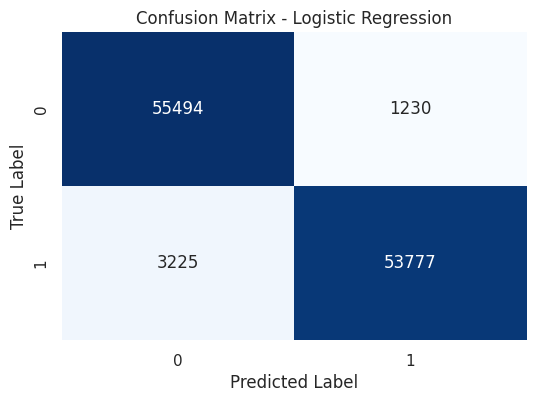

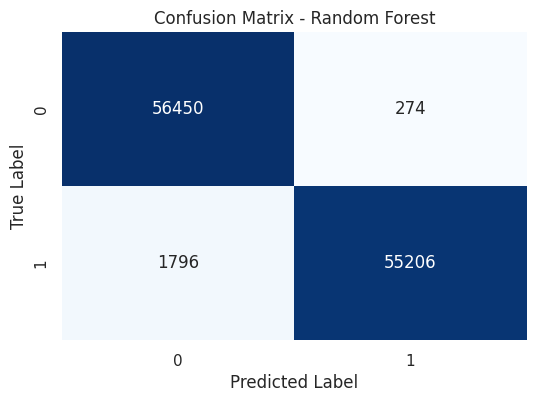

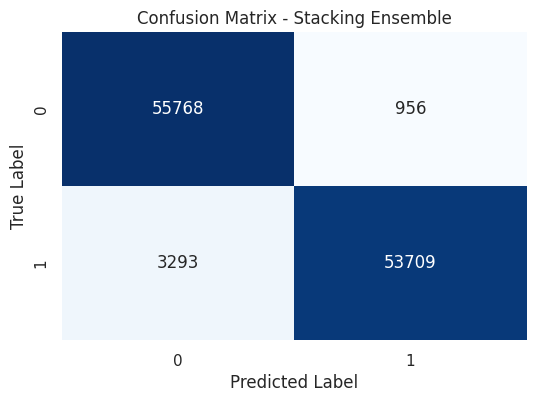

In [69]:
import seaborn as sns

# Helper function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_stacking, "Stacking Ensemble")


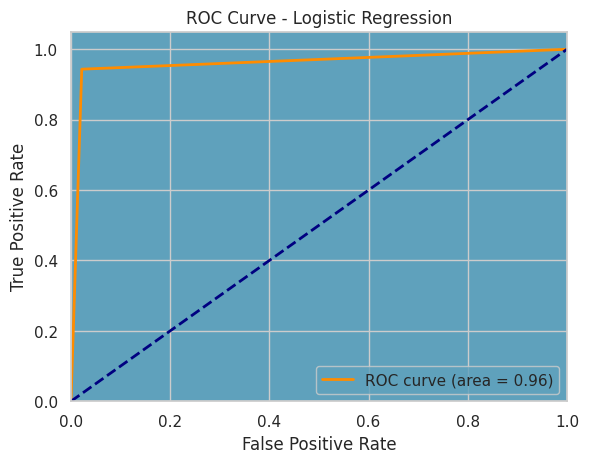

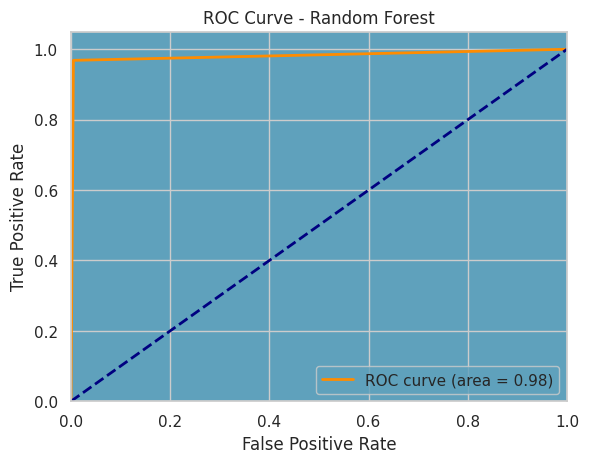

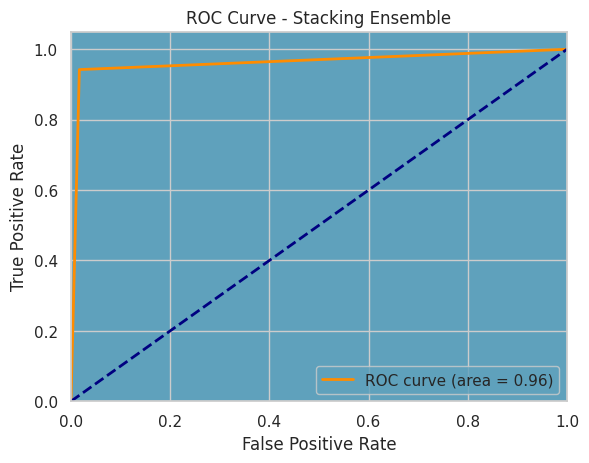

In [66]:
# Helper function to plot ROC curve
def plot_roc_curve(y_test, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(y_test, y_pred_logistic, "Logistic Regression")
plot_roc_curve(y_test, y_pred_rf, "Random Forest")
plot_roc_curve(y_test, y_pred_stacking, "Stacking Ensemble")



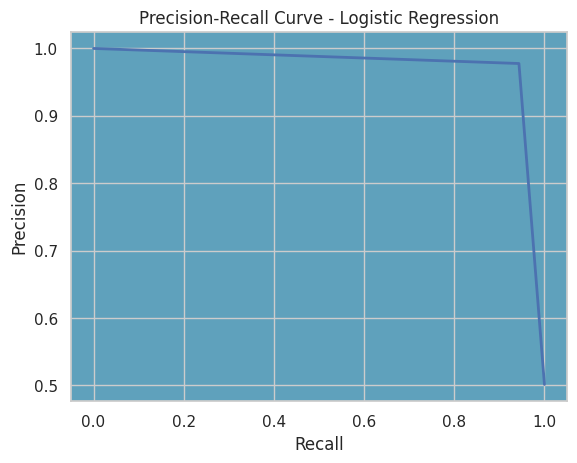

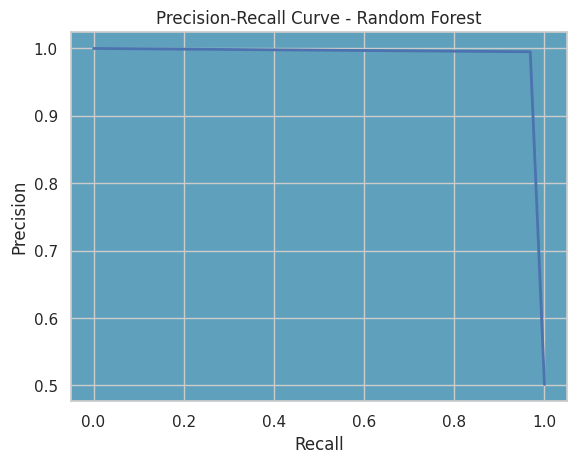

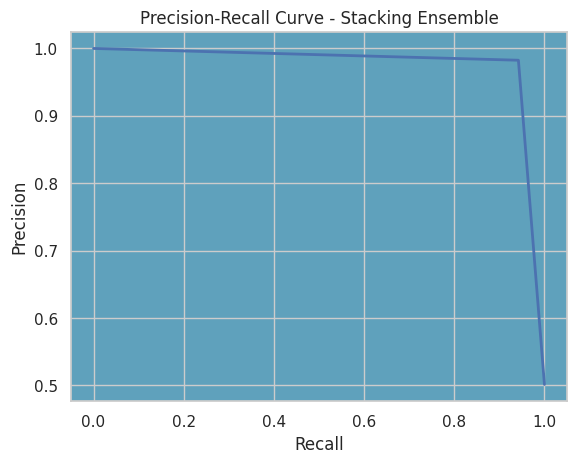

In [67]:
# Helper function to plot Precision-Recall curve
def plot_precision_recall_curve(y_test, y_pred, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.show()


plot_precision_recall_curve(y_test, y_pred_logistic, "Logistic Regression")
plot_precision_recall_curve(y_test, y_pred_rf, "Random Forest")
plot_precision_recall_curve(y_test, y_pred_stacking, "Stacking Ensemble")
